# Recheck/test tensor multiplications for mfBLM calculations
1/04/20

Currently packaged, but not working vs. benchmark N2/NO2 data - looks like some assumptions/previous tests were not valid.

Unbox it again and test with real matrix elements here.

Previous test & demo codes:
- http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_260220.ipynb
- http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_pt2_170320_tidy.ipynb
- http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_Betas_090320.ipynb

Previous multiplication testing: http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_Betas_090320.ipynb#Test-full-multiplication-terms...

Here use existing packaged code, and look at in more detail.

## Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

pd.options.display.max_rows = 100  # Default is 60

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

* pyevtk not found, VTK export not available. 


In [2]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
# dataSet = ep.readMatEle(fileIn = dataFile)
# dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.
dataSet = ep.readMatEle(fileBase = dataPath)
dataXS = ep.readMatEle(fileBase = dataPath, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning dir
D:\code\github\ePSproc\data\photoionization
Found 2 .out file(s)


*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\no2_demo_ePS.out
Expecting 1 energy points.
Expecting 3 symmetries.
Scanning CrossSection segments.
Expecting 3 DumpIdy segments.
Found 3 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 3 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning dir
D:\code\github\ePSproc\data\photoionization
Found 2 .out f

## Set matrix elements for testing

Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


Eke                          0.1        1.1       2.1       3.1       4.1   \
Cont Targ Total l m  mu                                                      
PU   SG   PU    1 -1  1 -6.203556   7.496908  3.926892  1.071093 -0.335132   
                   1 -1 -6.203556   7.496908  3.926892  1.071093 -0.335132   
                3 -1  1 -2.090641  -1.723467 -3.571018 -1.703191  0.232612   
                   1 -1 -2.090641  -1.723467 -3.571018 -1.703191  0.232612   
                5 -1  1       NaN        NaN       NaN       NaN       NaN   
                   1 -1       NaN        NaN       NaN       NaN       NaN   
SU   SG   SU    1  0  0  6.246520 -10.081763 -8.912214 -5.342049 -3.160539   
                3  0  0  2.605768   2.775108  4.733473  1.677812 -1.450830   
                5  0  0       NaN        NaN       NaN  0.024263  0.042694   
                7  0  0       NaN        NaN       NaN       NaN       NaN   

Eke                          5.1       6.1       7.1        8.1        9.1   \
Cont Targ Total l m  mu                                                       
PU   SG   PU    1 -1  1 -1.043391 -1.396885 -1.554984  -1.598812  -1.573327   
                   1 -1 -1.043391 -1.396885 -1.554984  -1.598812  -1.573327   
                3 -1  1  1.862713  3.201022  4.298839   5.198215   5.929303   
                   1 -1  1.862713  3.201022  4.298839   5.198215   5.929303   
                5 -1  1       NaN -0.042762 -0.053765  -0.067354  -0.083946   
                   1 -1       NaN -0.042762 -0.053765  -0.067354  -0.083946   
SU   SG   SU    1  0  0 -1.795783 -0.867993 -0.174154   0.400643   0.926420   
                3  0  0 -4.187395 -6.554491 -8.601759 -10.343109 -11.747922   
                5  0  0  0.059142  0.077308  0.099330   0.126227   0.157745   
                7  0  0       NaN       NaN       NaN        NaN        NaN   

Eke                      ...      41.1      42.1      43.1      44.1  \
Cont Targ Total l m  mu  ...                                           
PU   SG   PU    1 -1  1  ... -0.396306 -0.422225 -0.448003 -0.473466   
                   1 -1  ... -0.396306 -0.422225 -0.448003 -0.473466   
                3 -1  1  ...  1.200463  1.040074  0.892501  0.757189   
                   1 -1  ...  1.200463  1.040074  0.892501  0.757189   
                5 -1  1  ... -0.325544 -0.318791 -0.312332 -0.306211   
                   1 -1  ... -0.325544 -0.318791 -0.312332 -0.306211   
SU   SG   SU    1  0  0  ... -0.854886 -0.940017 -1.021577 -1.099776   
                3  0  0  ... -0.293053 -0.441416 -0.579578 -0.708075   
                5  0  0  ...  0.490499  0.511546  0.531810  0.551281   
                7  0  0  ...       NaN       NaN       NaN -0.045092   

Eke                          45.1      46.1      47.1      48.1      49.1  \
Cont Targ Total l m  mu                                                     
PU   SG   PU    1 -1  1 -0.498463 -0.522867 -0.546573 -0.569493 -0.591558   
                   1 -1 -0.498463 -0.522867 -0.546573 -0.569493 -0.591558   
                3 -1  1  0.633556  0.521004  0.418928  0.326726  0.243800   
                   1 -1  0.633556  0.521004  0.418928  0.326726  0.243800   
                5 -1  1 -0.300456 -0.295091 -0.290130 -0.285584 -0.281453   
                   1 -1 -0.300456 -0.295091 -0.290130 -0.285584 -0.281453   
SU   SG   SU    1  0  0 -1.174787 -1.246759 -1.315814 -1.382058 -1.445582   
                3  0  0 -0.827415 -0.938075 -1.040506 -1.135134 -1.222361   
                5  0  0  0.569951  0.587815  0.604868  0.621107  0.636528   
                7  0  0 -0.046901 -0.048689 -0.050453 -0.052190 -0.053899   

Eke                          50.1  
Cont Targ Total l m  mu            
PU   SG   PU    1 -1  1 -0.612712  
                   1 -1 -0.612712  
                3 -1  1  0.169566  
                   1 -1  0.169566  
                5 -1  1 -0.277737  
                   1 -1 -0.277737  
SU   SG   SU    1  0  0 -1.506467  


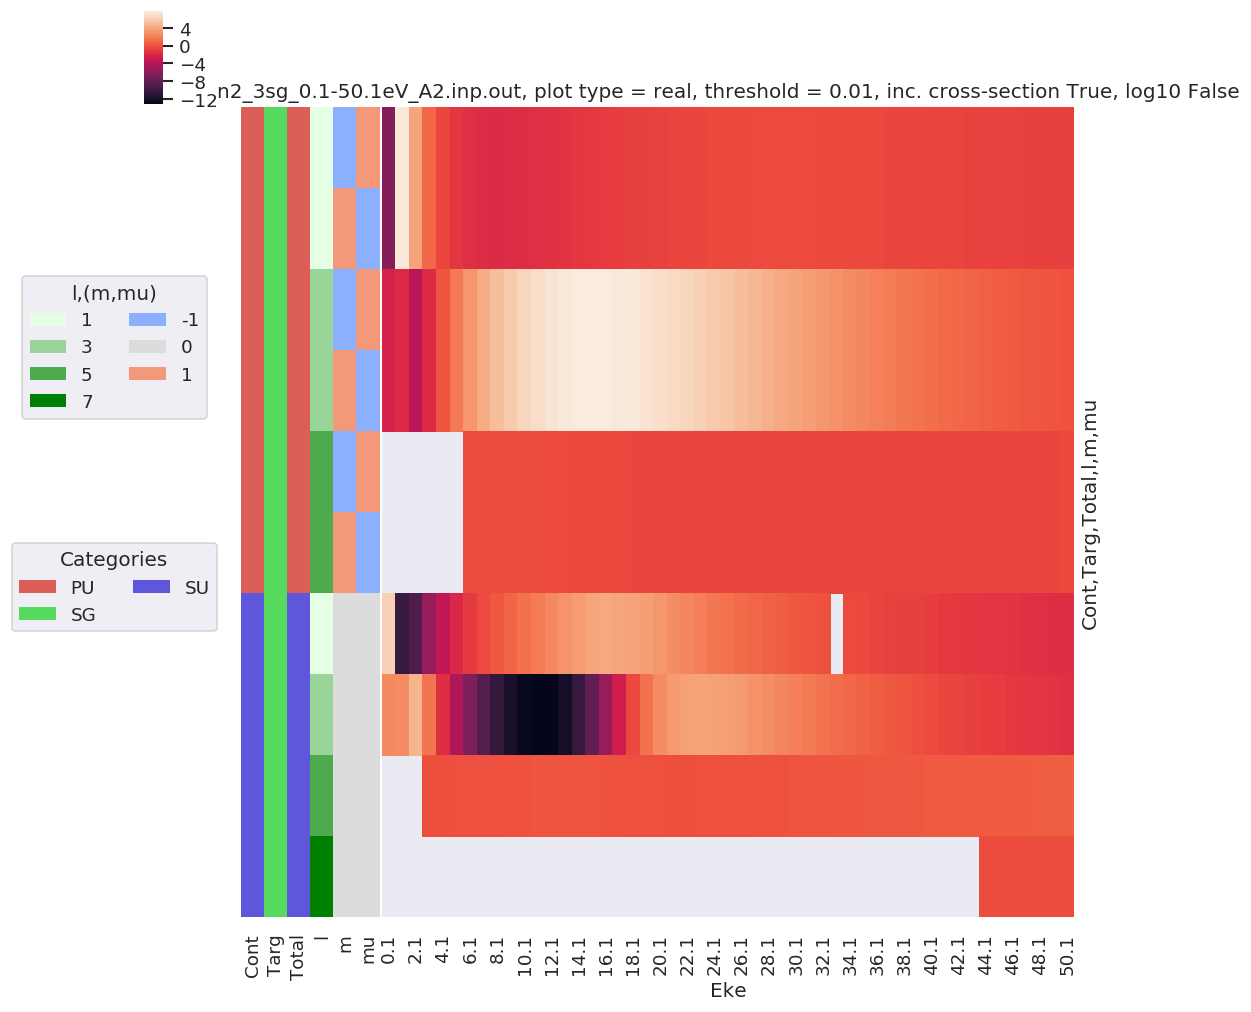

In [3]:
# Set for a single set of matrix elements for testing
dataNsel = 0
# matE = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'Eke':0.1, 'it':1, 'Type':'L'})
matE = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'it':1, 'Type':'L'})

# Plot vs. (l,m)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, plotDims = ['Cont', 'Targ', 'Total', 'mu'], xDim = {'LM':['l','m']}, pType = 'r')

# Plot vs. Eke
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, pType = 'r')

daPlotpd

## Function code
 From mfblmGeom.py, version as of 1/4/20

In [4]:
matEin = dataSet[dataNsel].sel({'Cont':'SU'})

phaseConvention = 'E'

RX = ep.setPolGeoms()  # Set default pol geoms, or will be set by MFproj()

In [5]:
# Other function defaults
QNs = None
EPRX = None
p=[0]
BLMtable = None
lambdaTerm = None
# RX = None
eulerAngs = None
thres = 1e-1
thresDims = 'Eke'
selDims = {'it':1, 'Type':'L'}
sumDims = ['mu', 'mup', 'l','lp','m','mp']
sumDimsPol = ['P','R','p','Rp']   # ['P','R','Rp','p']  # Dims to sum pol terms *BEFORE* multiplication
symSum = True
SFflag = False
squeeze = False

In [6]:
# For transparency/consistency with subfunctions, str/dict now set in setPhaseConventions()
phaseCons = geomCalc.setPhaseConventions(phaseConvention = phaseConvention)

# Fudge - set this for now to enforce additonal unstack and phase corrections later.
BLMtableResort = None

#*** Threshold and selection
# Make explicit copy of data to avoid any overwrite issues
matE = matEin.copy()
matE.attrs = matEin.attrs  # May not be necessary with updated Xarray versions

# Use SF (scale factor)
# Write to data.values to make sure attribs are maintained. (Not the case for da = da*da.SF)
if SFflag:
    matE.values = matE * matE.SF

matEthres = matEleSelector(matE, thres = thres, inds = selDims, dims = thresDims, sq = True, drop = True)

# Sum **AFTER** threshold and selection, to allow for subselection on symmetries via matEleSelector
if symSum:
    if 'Sym' in matEthres.dims:
        matEthres = matEthres.sum('Sym')  # Sum over ['Cont','Targ','Total'] stacked dims.   #*** FOR TESTING SET AT MATMULT CELLS

# Set terms if not passed to function
# if QNs is None:
#     QNs = geomCalc.genllpMatE(matEthres, phaseConvention = phaseConvention)


In [7]:
# Check QN generation more carefully... seem to be missing some combinations at the moment...?  Might be due to phase terms later...
# Code from genllpMatE()

# phaseCons['genMatEcons']['negm'] = False
mFlag = True
uniqueFlag = True

lList = matEthres.unstack().l.values
if mFlag:
    mList = matE.unstack().m.values
else:
    mList = 0
    
# Set QNs for calculation, (l,m,mp)
QNs = []
for l in lList:
    for lp in lList:
        for m in mList:
            for mp in mList:
                for L in np.arange(np.abs(l-lp), l+lp+1):
                    # Set M - note this implies specific phase choice.
                    if phaseCons['genMatEcons']['negm']:
                        M = (-m+mp)
                    else:
                        M = -(m+mp)  

                    # This is likely redundant/misguided, since already implied in phase convention above.
                    # if phaseCons['genMatEcons']['negM']:
                    #     M *= -1

#                     for M in np.arange(0, L+1):
                    if np.abs(M) <= L:  # Skip terms with invalid M
                        QNs.append([l, lp, L, m, mp, M])

                    # Run for all possible M
                    # for M in np.arange(-L, L+1):
                        # QNs.append([l, lp, L, m, mp, M])

if uniqueFlag:
    QNs = np.unique(QNs, axis = 0)


### Polarization terms

In [8]:
EPRX = None   # Reset terms to allow repeated calcs for testing!
lambdaTerm = None

# phaseCons['lambdaCons']['negMup'] = False  # FOR TESTING ONLY!!!
# phaseCons['lambdaCons']['negRp'] = False  # FOR TESTING ONLY!!!
# phaseCons['EPR']['negR'] = True  # FOR TESTING ONLY!!!

#*** Polarization terms
if EPRX is None:
    # *** EPR
    # EPRX = geomCalc.EPR(form = 'xarray', p = p, phaseConvention = phaseConvention).sel({'R-p':0})  # Set for R-p = 0 for p=0 case (redundant coord) - need to fix in e-field mult term!
    # EPRXresort = EPRX.unstack().squeeze().drop('l').drop('lp')  # This removes photon (l,lp) dims fully. Be careful with squeeze() - sends singleton dims to non-dimensional labels.
#         EPRXresort = EPRX.unstack().drop('l').drop('lp')  # This removes photon (l,lp) dims fully, but keeps (p,R) as singleton dims.
#         EPRXresort = EPRX.unstack().squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

#         EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sum(['p','R-p'])  # Set for general sum over (p,R-p) terms - STILL need to fix in e-field mult term!
#         EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sum('R-p')  # Set for general sum over (p,R-p) terms - STILL need to fix in e-field mult term!
#     EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sel({'R-p':0}).drop('R-p')
    EPRX = geomCalc.EPR(form = 'xarray', p = p, phaseConvention=phaseCons).unstack()  # Keep all terms
    EPRXresort = EPRX.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

    if phaseCons['mfblmCons']['negRcoordSwap']:
        EPRXresort['R'] *= -1

if lambdaTerm is None:
    # Set polGeoms if Euler angles are passed.
    if eulerAngs is not None:
        RX = setPolGeoms(eulerAngs = eulerAngs)

    # *** Lambda term
    lambdaTerm, lambdaTable, lambdaD, QNsLambda = geomCalc.MFproj(RX = RX, form = 'xarray', phaseConvention = phaseCons)
    # lambdaTermResort = lambdaTerm.squeeze().drop('l').drop('lp')   # This removes photon (l,lp) dims fully.
    lambdaTermResort = lambdaTerm.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.


No handles with labels found to put in legend.


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


,,P,0,1,2
R,R-p,p,,,
-1,1,0,NaN,-0.707107,0.707107
0,0,0,-0.57735,NaN,0.816497
1,-1,0,NaN,0.707107,0.707107


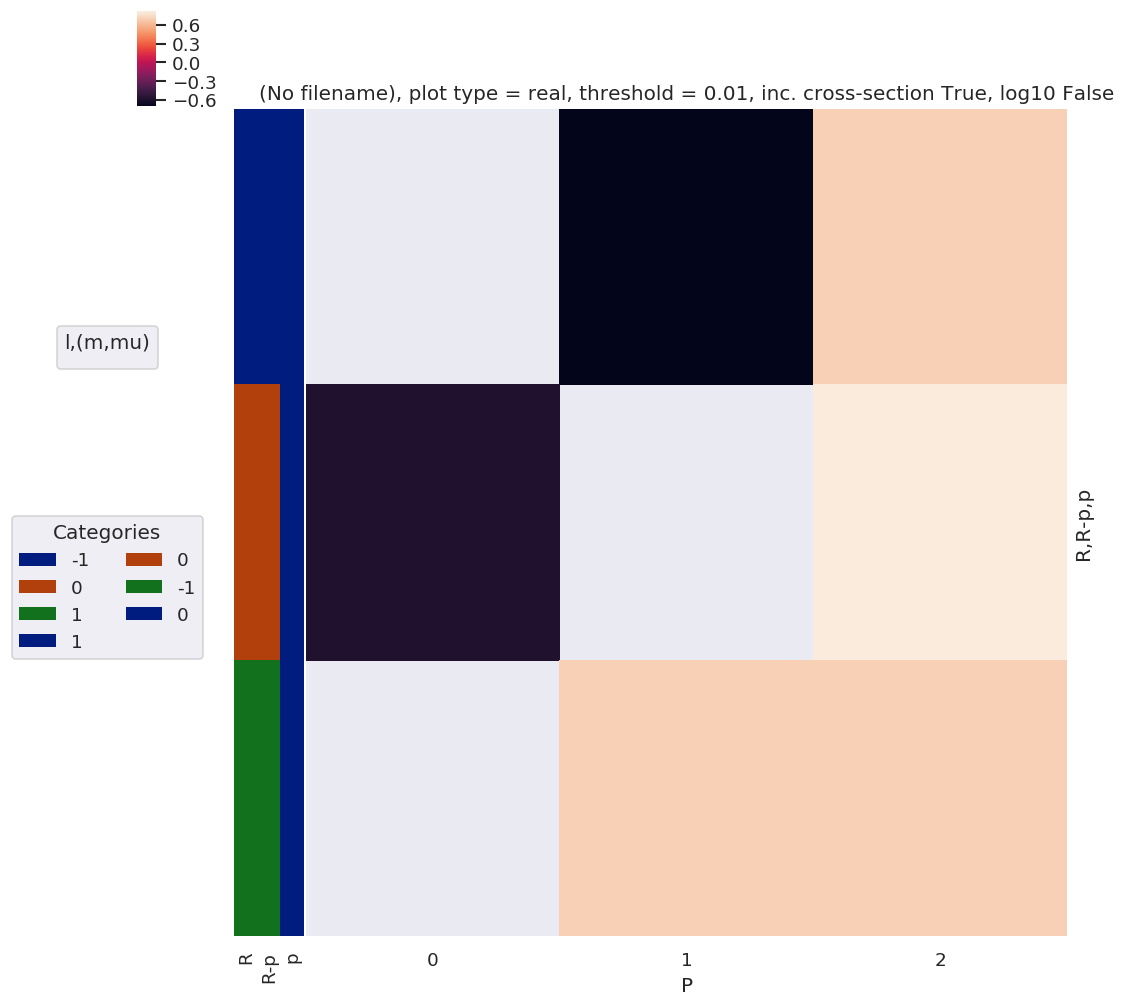

In [9]:
# Plotting - EPRXresort
# Default case has R=0 only.

daPlot, daPlotpd, legendList, gFig = ep.lmPlot(EPRXresort, xDim='P', pType = 'r')
daPlotpd

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


Labels                 z         x         y
P R  Rp mu mup                              
0  0  0 -1  1   0.577350  0.577350  0.577350
         0  0  -0.577350 -0.577350 -0.577350
         1 -1   0.577350  0.577350  0.577350
1 -1 -1  0  1  -0.408248 -0.204124       NaN
         1  0   0.408248  0.204124       NaN
      0 -1  1        NaN -0.288675 -0.288675
         1 -1        NaN  0.288675  0.288675
      1 -1  0        NaN -0.204124       NaN
         0 -1        NaN  0.204124       NaN
   0 -1  0  1        NaN  0.288675       NaN
         1  0        NaN -0.288675       NaN
      0 -1  1  -0.408248       NaN       NaN
         1 -1   0.408248       NaN       NaN
      1 -1  0        NaN -0.288675       NaN
         0 -1        NaN  0.288675       NaN
   1 -1  0  1        NaN -0.204124       NaN
         1  0        NaN  0.204124       NaN
      0 -1  1        NaN  0.288675  0.288675
         1 -1        NaN -0.288675 -0.288675
      1 -1  0  -0.408248 -0.204124       NaN
         0 -1   0.408248  0.204124       NaN
2 -2 -2  1  1   0.447214  0.111803 -0.111803
     -1  0  1        NaN  0.158114       NaN
         1  0        NaN  0.158114       NaN
      0 -1  1        NaN  0.111803  0.111803
         0  0        NaN  0.223607  0.223607
         1 -1        NaN  0.111803  0.111803
      1 -1  0        NaN  0.158114       NaN
         0 -1        NaN  0.158114       NaN
      2 -1 -1        NaN  0.111803 -0.111803
  -1 -2  1  1        NaN -0.223607  0.223607
     -1  0  1   0.316228 -0.158114       NaN
         1  0   0.316228 -0.158114       NaN
      1 -1  0        NaN  0.158114       NaN
         0 -1        NaN  0.158114       NaN
      2 -1 -1        NaN  0.223607 -0.223607
   0 -2  1  1        NaN  0.273861 -0.273861
      0 -1  1   0.182574 -0.091287 -0.091287
         0  0   0.365148 -0.182574 -0.182574
         1 -1   0.182574 -0.091287 -0.091287
      2 -1 -1        NaN  0.273861 -0.273861
   1 -2  1  1        NaN -0.223607  0.223607
     -1  0  1        NaN  0.158114       NaN
         1  0        NaN  0.158114       NaN
      1 -1  0   0.316228 -0.158114       NaN
         0 -1   0.316228 -0.158114       NaN
      2 -1 -1        NaN  0.223607 -0.223607
   2 -2  1  1        NaN  0.111803 -0.111803
     -1  0  1        NaN -0.158114       NaN
         1  0        NaN -0.158114       NaN
      0 -1  1        NaN  0.111803  0.111803
         0  0        NaN  0.223607  0.223607
         1 -1        NaN  0.111803  0.111803
      1 -1  0        NaN -0.158114       NaN
         0 -1        NaN -0.158114       NaN
      2 -1 -1   0.447214  0.111803 -0.111803

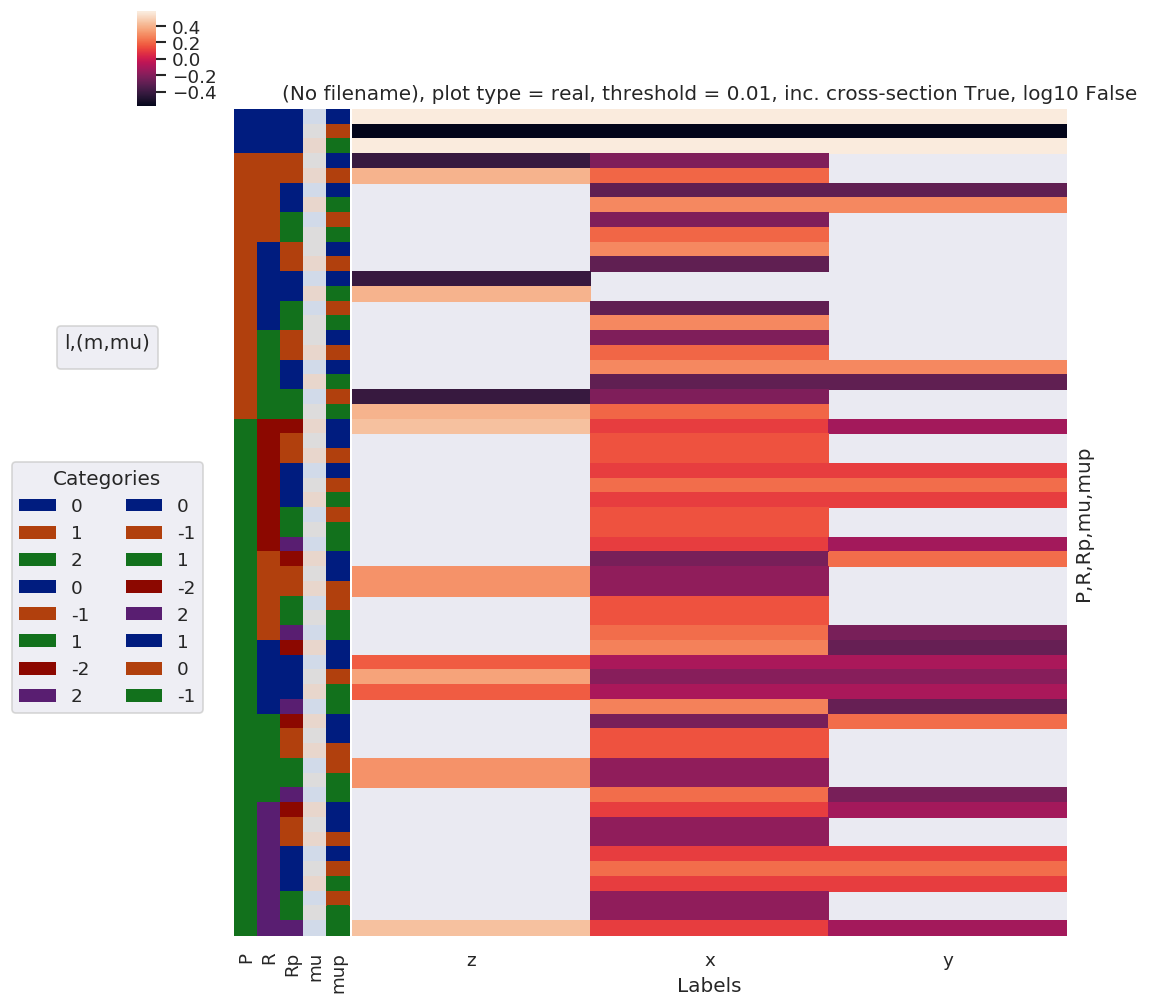

In [10]:
# Plotting - lambdaTermResort

daPlot, daPlotpd, legendList, gFig = ep.lmPlot(lambdaTermResort, xDim='Labels', pType = 'r')
daPlotpd

In [11]:
# Check complex values...
xDim = 'Labels'
lambdaTermResortpd, _ = ep.util.multiDimXrToPD(lambdaTermResort, colDims=xDim, thres = 1e-2)
lambdaTermResortpd

Labels                           z                   x                   y
P R  Rp mu mup                                                            
0  0  0 -1  1   0.577350+0.000000j  0.577350+0.000000j  0.577350+0.000000j
         0  0  -0.577350+0.000000j -0.577350+0.000000j -0.577350+0.000000j
         1 -1   0.577350+0.000000j  0.577350+0.000000j  0.577350+0.000000j
1 -1 -1  0  1  -0.408248+0.000000j -0.204124+0.000000j -0.000000+0.204124j
         1  0   0.408248+0.000000j  0.204124+0.000000j  0.000000-0.204124j
      0 -1  1                  NaN -0.288675+0.000000j -0.288675+0.000000j
         1 -1                  NaN  0.288675+0.000000j  0.288675+0.000000j
      1 -1  0                  NaN -0.204124+0.000000j -0.000000-0.204124j
         0 -1                  NaN  0.204124+0.000000j  0.000000+0.204124j
   0 -1  0  1                  NaN  0.288675-0.000000j  0.000000-0.288675j
         1  0                  NaN -0.288675+0.000000j -0.000000+0.288675j
      0 -1  1  -0.408248+0.000000j                 NaN                 NaN
         1 -1   0.408248+0.000000j                 NaN                 NaN
      1 -1  0                  NaN -0.288675+0.000000j -0.000000-0.288675j
         0 -1                  NaN  0.288675+0.000000j  0.000000+0.288675j
   1 -1  0  1                  NaN -0.204124+0.000000j -0.000000+0.204124j
         1  0                  NaN  0.204124+0.000000j  0.000000-0.204124j
      0 -1  1                  NaN  0.288675-0.000000j  0.288675-0.000000j
         1 -1                  NaN -0.288675+0.000000j -0.288675+0.000000j
      1 -1  0  -0.408248+0.000000j -0.204124+0.000000j -0.000000-0.204124j
         0 -1   0.408248+0.000000j  0.204124+0.000000j  0.000000+0.204124j
2 -2 -2  1  1   0.447214+0.000000j  0.111803+0.000000j -0.111803-0.000000j
     -1  0  1                  NaN  0.158114+0.000000j  0.000000-0.158114j
         1  0                  NaN  0.158114+0.000000j  0.000000-0.158114j
      0 -1  1                  NaN  0.111803+0.000000j  0.111803+0.000000j
         0  0                  NaN  0.223607+0.000000j  0.223607+0.000000j
         1 -1                  NaN  0.111803+0.000000j  0.111803+0.000000j
      1 -1  0                  NaN  0.158114+0.000000j  0.000000+0.158114j
         0 -1                  NaN  0.158114+0.000000j  0.000000+0.158114j
      2 -1 -1                  NaN  0.111803+0.000000j -0.111803+0.000000j
  -1 -2  1  1                  NaN -0.223607+0.000000j  0.223607+0.000000j
     -1  0  1   0.316228+0.000000j -0.158114-0.000000j -0.000000+0.158114j
         1  0   0.316228+0.000000j -0.158114-0.000000j -0.000000+0.158114j
      1 -1  0                  NaN  0.158114+0.000000j  0.000000+0.158114j
         0 -1                  NaN  0.158114+0.000000j  0.000000+0.158114j
      2 -1 -1                  NaN  0.223607+0.000000j -0.223607+0.000000j
   0 -2  1  1                  NaN  0.273861+0.000000j -0.273861-0.000000j
      0 -1  1   0.182574+0.000000j -0.091287-0.000000j -0.091287-0.000000j
         0  0   0.365148+0.000000j -0.182574-0.000000j -0.182574-0.000000j
         1 -1   0.182574+0.000000j -0.091287-0.000000j -0.091287-0.000000j
      2 -1 -1                  NaN  0.273861+0.000000j -0.273861+0.000000j
   1 -2  1  1                  NaN -0.223607+0.000000j  0.223607+0.000000j
     -1  0  1                  NaN  0.158114+0.000000j  0.000000-0.158114j
         1  0                  NaN  0.158114+0.000000j  0.000000-0.158114j
      1 -1  0   0.316228+0.000000j -0.158114-0.000000j -0.000000-0.158114j
         0 -1   0.316228+0.000000j -0.158114-0.000000j -0.000000-0.158114j
      2 -1 -1                  NaN  0.223607+0.000000j -0.223607+0.000000j
   2 -2  1  1                  NaN  0.111803+0.000000j -0.111803-0.000000j
     -1  0  1                  NaN -0.158114+0.000000j -0.000000+0.158114j
         1  0                  NaN -0.158114+0.000000j -0.000000+0.158114j
      0 -1  1                  NaN  0.111803+0.000000j  0.111803+0.000000j
         0  0            

In [12]:
# Check complex values for Lambda component terms...
xDim = 'Rp'
lambdaTablepd, _ = ep.util.multiDimXrToPD(lambdaTable, colDims=xDim, thres = 1e-2)
lambdaTablepd

Rp                      -2        -1         0         1         2
P R  l lp mu mup                                                  
0  0 1 1  -1  1        NaN       NaN  0.577350       NaN       NaN
           0  0        NaN       NaN -0.577350       NaN       NaN
           1 -1        NaN       NaN  0.577350       NaN       NaN
1 -1 1 1  -1  0        NaN       NaN       NaN  0.408248       NaN
              1        NaN       NaN -0.408248       NaN       NaN
           0 -1        NaN       NaN       NaN -0.408248       NaN
              1        NaN  0.408248       NaN       NaN       NaN
           1 -1        NaN       NaN  0.408248       NaN       NaN
              0        NaN -0.408248       NaN       NaN       NaN
   0 1 1  -1  0        NaN       NaN       NaN  0.408248       NaN
              1        NaN       NaN -0.408248       NaN       NaN
           0 -1        NaN       NaN       NaN -0.408248       NaN
              1        NaN  0.408248       NaN       NaN       NaN
           1 -1        NaN       NaN  0.408248       NaN       NaN
              0        NaN -0.408248       NaN       NaN       NaN
   1 1 1  -1  0        NaN       NaN       NaN  0.408248       NaN
              1        NaN       NaN -0.408248       NaN       NaN
           0 -1        NaN       NaN       NaN -0.408248       NaN
              1        NaN  0.408248       NaN       NaN       NaN
           1 -1        NaN       NaN  0.408248       NaN       NaN
              0        NaN -0.408248       NaN       NaN       NaN
2 -2 1 1  -1 -1        NaN       NaN       NaN       NaN  0.447214
              0        NaN       NaN       NaN -0.316228       NaN
              1        NaN       NaN  0.182574       NaN       NaN
           0 -1        NaN       NaN       NaN -0.316228       NaN
              0        NaN       NaN  0.365148       NaN       NaN
              1        NaN -0.316228       NaN       NaN       NaN
           1 -1        NaN       NaN  0.182574       NaN       NaN
              0        NaN -0.316228       NaN       NaN       NaN
              1   0.447214       NaN       NaN       NaN       NaN
  -1 1 1  -1 -1        NaN       NaN       NaN       NaN  0.447214
              0        NaN       NaN       NaN -0.316228       NaN
              1        NaN       NaN  0.182574       NaN       NaN
           0 -1        NaN       NaN       NaN -0.316228       NaN
              0        NaN       NaN  0.365148       NaN       NaN
              1        NaN -0.316228       NaN       NaN       NaN
           1 -1        NaN       NaN  0.182574       NaN       NaN
              0        NaN -0.316228       NaN       NaN       NaN
              1   0.447214       NaN       NaN       NaN       NaN
   0 1 1  -1 -1        NaN       NaN       NaN       NaN  0.447214
              0        NaN       NaN       NaN -0.316228       NaN
              1        NaN       NaN  0.182574       NaN       NaN
           0 -1        NaN       NaN       NaN -0.316228       NaN
              0        NaN       NaN  0.365148       NaN       NaN
              1        NaN -0.316228       NaN       NaN       NaN
           1 -1        NaN       NaN  0.182574       NaN       NaN
              0        NaN -0.316228       NaN       NaN       NaN
              1   0.447214       NaN       NaN       NaN       NaN
   1 1 1  -1 -1        NaN       NaN       NaN       NaN  0.447214
              0        NaN       NaN       NaN -0.316228       NaN
              1        NaN       NaN  0.182574       NaN       NaN
           0 -1        NaN       NaN       NaN -0.316228       NaN
              0        NaN       NaN  0.365148       NaN       NaN
              1        NaN -0.316228       NaN       NaN       NaN
           1 -1        NaN       NaN  0.182574       NaN       NaN
              0        NaN -0.316228       NaN       NaN       NaN
              1   0.447214       NaN       NaN       NaN       NaN
   2 1 1  -1 -1        NaN       NaN       NaN 

In [13]:
# Check vs. basic 3j term
test3j = ep.geomFunc.w3jTable(Lmin=1, Lmax=1, form='xarray')
tablepd, _ = ep.util.multiDimXrToPD(test3j.unstack(), colDims='M', thres = 1e-2)
tablepd

M                   -2        -1         0         1         2
L l lp m  mp                                                  
0 1 1  -1  1       NaN       NaN  0.577350       NaN       NaN
        0  0       NaN       NaN -0.577350       NaN       NaN
        1 -1       NaN       NaN  0.577350       NaN       NaN
1 1 1  -1  0       NaN       NaN       NaN  0.408248       NaN
           1       NaN       NaN -0.408248       NaN       NaN
        0 -1       NaN       NaN       NaN -0.408248       NaN
           1       NaN  0.408248       NaN       NaN       NaN
        1 -1       NaN       NaN  0.408248       NaN       NaN
           0       NaN -0.408248       NaN       NaN       NaN
2 1 1  -1 -1       NaN       NaN       NaN       NaN  0.447214
           0       NaN       NaN       NaN -0.316228       NaN
           1       NaN       NaN  0.182574       NaN       NaN
        0 -1       NaN       NaN       NaN -0.316228       NaN
           0       NaN       NaN  0.365148       NaN       NaN
           1       NaN -0.316228       NaN       NaN       NaN
        1 -1       NaN       NaN  0.182574       NaN       NaN
           0       NaN -0.316228       NaN       NaN       NaN
           1  0.447214       NaN       NaN       NaN       NaN

In [14]:
#********************** Pol product term
polProd = (EPRXresort * lambdaTermResort)  # Without polarization terms sum to allow for mupPhase below (reqs. p)

# Set additional phase term, (-1)^(mup-p) **** THIS MIGHT BE SPURIOUS FOR GENERAL EPR TENSOR CASE??? Not sure... but definitely won't work if p summed over above!
if phaseCons['mfblmCons']['mupPhase']:
    mupPhaseTerm = np.power(-1, np.abs(polProd.mup - polProd.p))
    polProd *= mupPhaseTerm

# Additional [P]^1/2 degen term, NOT included in EPR defn.
# Added 09/04/20
polProd *= np.sqrt(2*polProd.P+1)

polTest = polProd.sel({'R-p':0})  #.sum('Rp')  # Set test term to check pre-summed values.

polProd = polProd.sum(sumDimsPol)  #************** TO TEST - sum here OK???

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


Labels        z         x         y
R-p mu mup                         
-1  -1 -1   NaN -0.353553  0.353553
        0   NaN -0.500000       NaN
        1   NaN -0.353553 -0.353553
     0 -1  -1.0       NaN       NaN
     1 -1   NaN  0.353553  0.353553
        0   NaN  0.500000       NaN
        1   NaN  0.353553 -0.353553
 0  -1 -1   NaN -0.500000  0.500000
        1   NaN  0.500000  0.500000
     0  0   1.0       NaN       NaN
     1 -1   NaN  0.500000  0.500000
        1   NaN -0.500000  0.500000
 1  -1 -1   NaN -0.353553  0.353553
        0   NaN  0.500000       NaN
        1   NaN -0.353553 -0.353553
     0  1  -1.0       NaN       NaN
     1 -1   NaN  0.353553  0.353553
        0   NaN -0.500000       NaN
        1   NaN  0.353553 -0.353553

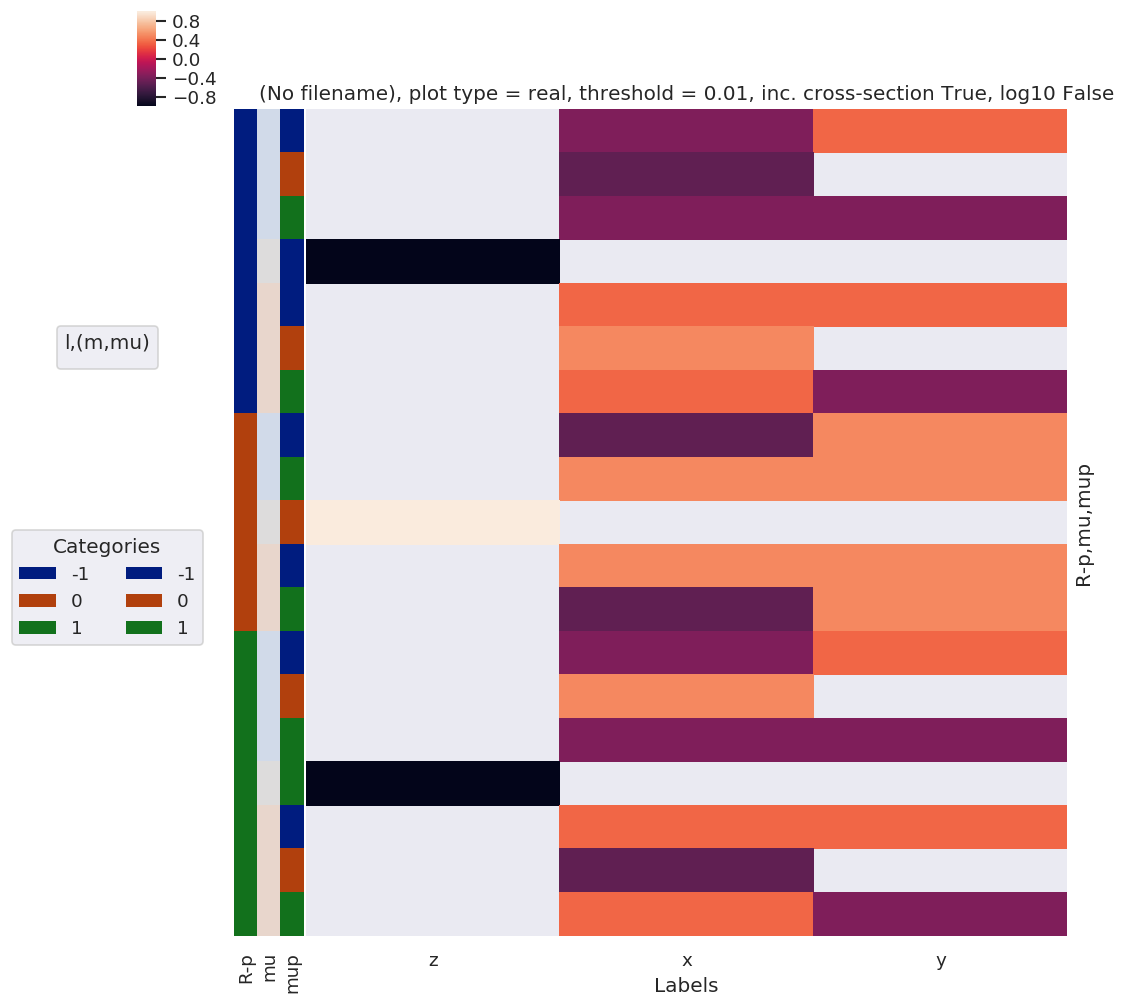

In [15]:
# Plotting - ploProd
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(polProd, xDim='Labels', pType = 'r')
daPlotpd

In [16]:
# Check complex values...
xDim = 'Labels'
polProdpd, _ = ep.util.multiDimXrToPD(polProd, colDims=xDim, thres = 1e-2)
polProdpd

# No imaginary terms here?  Seems odd...?

Labels                       z                   x                   y
R-p mu mup                                                            
-1  -1 -1                  NaN -0.353553+0.000000j  0.353553-0.000000j
        0                  NaN -0.500000+0.000000j -0.000000-0.500000j
        1                  NaN -0.353553+0.000000j -0.353553+0.000000j
     0 -1  -1.000000+0.000000j                 NaN                 NaN
     1 -1                  NaN  0.353553+0.000000j  0.353553+0.000000j
        0                  NaN  0.500000+0.000000j  0.000000-0.500000j
        1                  NaN  0.353553+0.000000j -0.353553-0.000000j
 0  -1 -1                  NaN -0.500000+0.000000j  0.500000-0.000000j
        1                  NaN  0.500000+0.000000j  0.500000+0.000000j
     0  0   1.000000+0.000000j                 NaN                 NaN
     1 -1                  NaN  0.500000+0.000000j  0.500000+0.000000j
        1                  NaN -0.500000+0.000000j  0.500000+0.000000j
 1  -1 -1                  NaN -0.353553+0.000000j  0.353553-0.000000j
        0                  NaN  0.500000+0.000000j  0.000000+0.500000j
        1                  NaN -0.353553+0.000000j -0.353553+0.000000j
     0  1  -1.000000+0.000000j                 NaN                 NaN
     1 -1                  NaN  0.353553+0.000000j  0.353553+0.000000j
        0                  NaN -0.500000+0.000000j -0.000000+0.500000j
        1                  NaN  0.353553+0.000000j -0.353553-0.000000j

## Test vs. original formulation (gamma P sum)

In [17]:
from epsproc.MFBLM import Wigner_D_element_Cached, Wigner3jCached

# Set test mu,mup
# muList = polProd.mu.data
muList = [-1,0,1]

R = 0
p = 0

# Set test (single) pol geom
polInd = 0
pRot = RX[polInd].values.item() 

EPRpolTerms = []
gammaPTerms = []
muProd = []
for mu1 in muList:
    for mu2 in muList:

        # Code adapted from MFBLM.py, **VERIFIED**

        # Gamma terms for polarization - sum over P
        gammaP = 0

        # Loop over allowed P = [0...2] for 2-photon case
        for P in np.arange(0, 3):
            Rp = mu2 - mu1     # mu2-mu1, includes Rp > -Rp for numerics.

            if np.abs(Rp) <= P:  # Check for allowed terms

                # Sum over R,R' projections omitted - only R=0 set above
                # Note polarization terms, here mu is MF, and p is LF.
                # Note use of matEprod.data here - otherwise output is kept as Xarray (which could be useful in future...)
                
                # Original version throws -ve powers error - why not in source code case?  Must only be assigning +ve Rp terms?
#                 term = (2*P+1) * (-1)**(Rp-R) * Wigner3jCached(1,1,P,mu1,-mu2,Rp) * Wigner3jCached(1,1,P,p,-p,R) * Wigner_D_element_Cached(pRot, P,-Rp,-R).conj()
                
                # With additional rewriting
                EPRpolTerm = Wigner3jCached(1,1,P,p,-p,R)
                term = (2*P+1) * (-1)**(np.abs(Rp-R)) * Wigner3jCached(1,1,P,mu1,-mu2,Rp) * Wigner_D_element_Cached(pRot, P,-Rp,-R).conj() * EPRpolTerm
                
                EPRpolTerms.append([P,p,R,EPRpolTerm])
                gammaP = gammaP + term
                gammaPTerms.append([P,Rp,mu1,-mu2,term])

                
        muProd.append([mu1, -mu2, gammaP])

In [18]:
pd.DataFrame(EPRpolTerms, columns=['P','p', 'R','Term']).sort_values(by='P')

,P,p,R,Term
0,0,0,0,-0.577350
16,0,0,0,-0.577350
8,0,0,0,-0.577350
14,1,0,0,0.000000
11,1,0,0,0.000000
17,1,0,0,0.000000
9,1,0,0,0.000000
3,1,0,0,0.000000
1,1,0,0,0.000000
6,1,0,0,0.000000


In [19]:
# Check complex values...
xDim = 'P'
lambdaTermResortpd, _ = ep.util.multiDimXrToPD(EPRXresort, colDims=xDim, thres = 1e-2)
lambdaTermResortpd

,,P,0,1,2
R,R-p,p,,,
-1,1,0,NaN,-0.707107,0.707107
0,0,0,-0.57735,NaN,0.816497
1,-1,0,NaN,0.707107,0.707107


In [20]:
pd.DataFrame(gammaPTerms, columns=['P','Rp','mu','mup','GammaP']).sort_values(by='P')

,P,Rp,mu,mup,GammaP
0,0,0,-1,1,-0.333333+0.000000j
16,0,0,1,-1,-0.333333+0.000000j
8,0,0,0,0,0.333333-0.000000j
14,1,-1,1,0,0.000000+0.000000j
11,1,1,0,-1,0.000000+0.000000j
17,1,0,1,-1,0.000000+0.000000j
9,1,0,0,0,0.000000+0.000000j
3,1,1,-1,0,0.000000+0.000000j
1,1,0,-1,1,-0.000000+0.000000j
6,1,-1,0,1,0.000000+0.000000j


In [21]:
pd.DataFrame(muProd, columns=['mu','mup','GammaP'])

,mu,mup,GammaP
0,-1,1,-5.551115e-17+0.000000e+00j
1,-1,0,0.000000e+00+0.000000e+00j
2,-1,-1,0.000000e+00+0.000000e+00j
3,0,1,0.000000e+00+0.000000e+00j
4,0,0,1.000000e+00+0.000000e+00j
5,0,-1,0.000000e+00+0.000000e+00j
6,1,1,0.000000e+00+0.000000e+00j
7,1,0,0.000000e+00+0.000000e+00j
8,1,-1,-5.551115e-17+0.000000e+00j


In [22]:
# polTest = polProd.sel({'R-p':0})  #.sum('Rp')  # Now set above to also allow for summed term with same name

# Tabulate
xDim = 'Labels'
# polProdpd, _ = ep.util.multiDimXrToPD(polTest, colDims=xDim, thres = 1e-2)
polProdpd, _ = ep.util.multiDimXrToPD(polTest.sum('P').sum('Rp'), colDims=xDim, thres = 1e-2)
polProdpd

# NOTE - to match existing case this should be +1, or +/-0.5, for allowed terms for (z,x,y) cases!

Labels                       z                   x                   y
R mu mup p                                                            
0 -1 -1  0                 NaN -0.500000+0.000000j  0.500000-0.000000j
      1  0                 NaN  0.500000+0.000000j  0.500000+0.000000j
   0  0  0  1.000000+0.000000j                 NaN                 NaN
   1 -1  0                 NaN  0.500000+0.000000j  0.500000+0.000000j
      1  0                 NaN -0.500000+0.000000j  0.500000+0.000000j

### BLMterm

In [23]:
# *** Blm term with specified QNs
# if BLMtable is None:

QNsBLMtable = QNs.copy()

# Switch signs (m,M) before 3j calcs.
if phaseCons['mfblmCons']['BLMmPhase']:
    QNsBLMtable[:,3] *= -1
    QNsBLMtable[:,5] *= -1

BLMtable = geomCalc.betaTerm(QNs = QNsBLMtable, form = 'xdaLM', phaseConvention = phaseConvention)

#         if BLMmPhase:
#             BLMtable['m'] *= -1

# if BLMtableResort is None:
    # Apply additional phase convention
BLMtableResort = BLMtable.copy().unstack()

if phaseCons['mfblmCons']['negMcoordSwap']:
    BLMtableResort['M'] *= -1

if phaseCons['mfblmCons']['Mphase']:
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.M))  # Associated phase term

if phaseCons['mfblmCons']['negmCoordSwap']:
    BLMtableResort['m'] *= -1

if phaseCons['mfblmCons']['mPhase']:
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.m))  # Associated phase term


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


L                 0         2                                           \
M                  0        -2        -1         0         1         2   
l lp m  mp                                                               
1 1  -1 -1       NaN       NaN       NaN       NaN       NaN -0.309019   
         0       NaN       NaN       NaN       NaN  0.218510       NaN   
         1  0.282095       NaN       NaN -0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.218510       NaN   
         0  0.282095       NaN       NaN  0.252313       NaN       NaN   
         1       NaN       NaN -0.218510       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN -0.126157       NaN       NaN   
         0       NaN       NaN  0.218510       NaN       NaN       NaN   
         1       NaN -0.309019       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN -0.143048       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.233597       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN -0.233597       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN -0.143048       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
3 1  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN  0.233597       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN  0.143048       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN  0.143048       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN  0.233597       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN -0.206013   
         0       NaN       NaN       NaN       NaN  0.059471       NaN   
         1  0.282095       NaN       NaN  0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.059471       NaN   
         0  0.282095       NaN       NaN  0.168209       NaN       NaN   
         1       NaN       NaN -0.059471       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN  0.126157       NaN       NaN   
         0       NaN       NaN  0.059471       NaN       NaN       NaN   
         1       NaN -0.206013       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN  0.092802   
         0       NaN       NaN       NaN       NaN -0.169433       NaN   
         1       NaN       NaN       NaN  0.227318       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.214318       NaN   
         0       NaN       NaN       NaN  0.239615       NaN       NaN   
         1       NaN       NaN -0.214318       NaN       NaN       NaN   
    

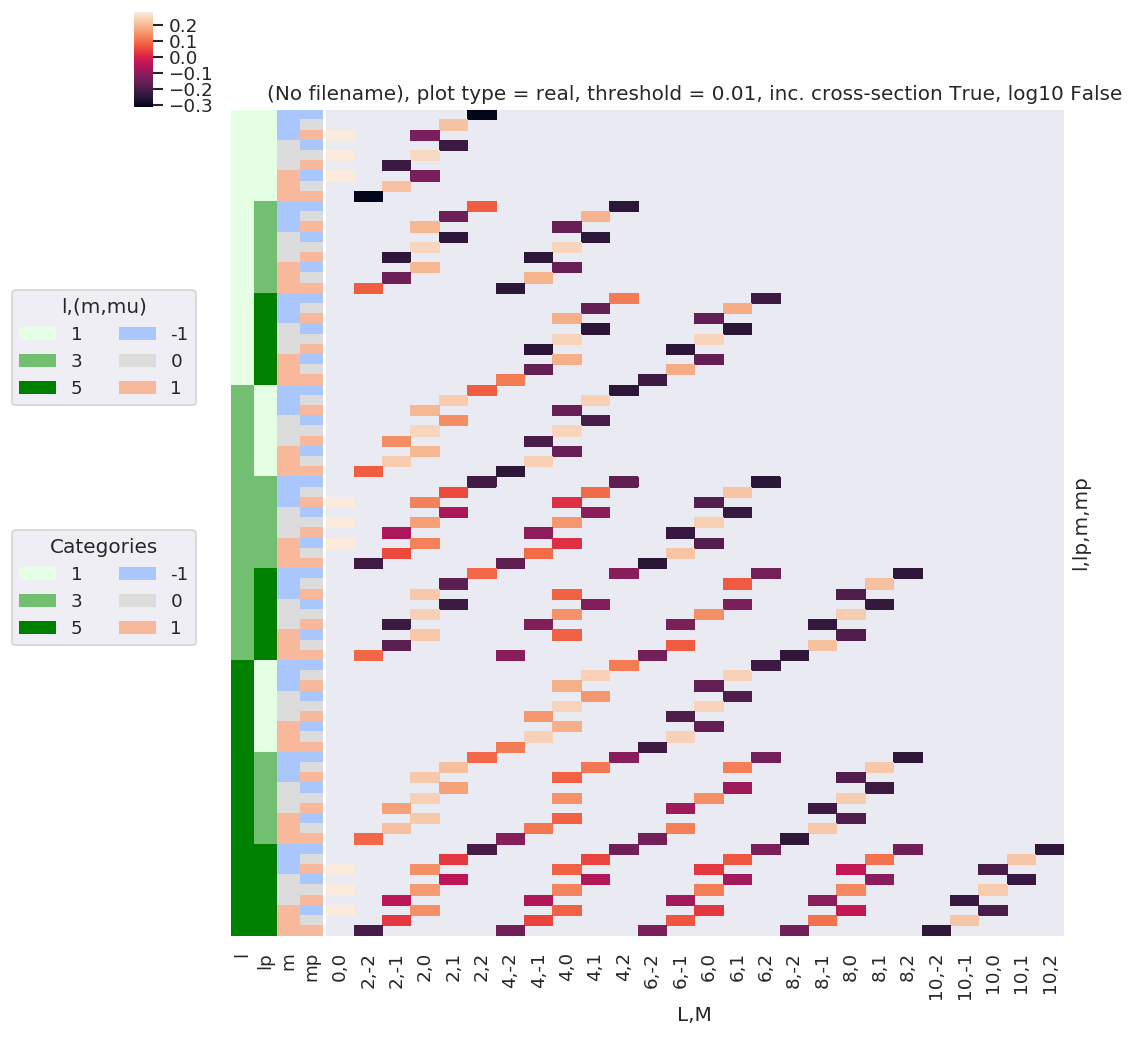

In [24]:
# Plotting - ploProd

daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtableResort, xDim={'LM':['L','M']}, pType = 'r')
daPlotpd

In [25]:
# Copy for testing later.
BLMtableResortFn = BLMtableResort.copy()

In [26]:
# Code from betaTerm() for additional testing
Lmin = 0
Lmax = 10
nonzeroFlag = True
form = 'xdaLM'
dlist = ['l', 'lp', 'L', 'm', 'mp', 'M']


if phaseCons['betaCons']['negM'] and (QNs is not None):
    QNs[:,-1] *= -1

# Tabulate 3j terms
BLMtable =  ep.geomFunc.w3jTable(QNs = QNs, Lmin = Lmin, Lmax = Lmax, nonzeroFlag = nonzeroFlag, form = form, dlist = dlist)

#******************** THIS PART TO CHECK!!!
# (1) Debugged genllLList()

QNsM0 = ep.geomFunc.geomUtils.genllLList(QNs, uniqueFlag = True, mFlag = False)
thrj0 = ep.geomFunc.w3jTable(QNs = QNsM0, nonzeroFlag = True, form = form, dlist = dlist)
BLMtable = BLMtable.unstack()*thrj0.drop('mSet').squeeze().unstack()

mPhase = np.power(-1, np.abs(BLMtable.m))
degen = (2*BLMtable.l+1)*(2*BLMtable.lp+1)*((2*BLMtable.L+1))/(4*np.pi)

if phaseCons['betaCons']['mPhase']:
    BLMtable *= mPhase*np.sqrt(degen)
else:
    BLMtable *= np.sqrt(degen)

BLMtable.attrs['dataType'] = 'betaTerm'
BLMtable.attrs['phaseCons'] = phaseCons


# *** And the resort code from mfblmGeom()

# Apply additional phase convention
BLMtableResort = BLMtable.copy().unstack()

if phaseCons['mfblmCons']['negMcoordSwap']:
    BLMtableResort['M'] *= -1

if phaseCons['mfblmCons']['Mphase']:
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.M))  # Associated phase term

if phaseCons['mfblmCons']['negmCoordSwap']:
    BLMtableResort['m'] *= -1

if phaseCons['mfblmCons']['mPhase']:
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.m))  # Associated phase term



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


L                 0         2                                           \
M                  0        -2        -1         0         1         2   
l lp m  mp                                                               
1 1  -1 -1       NaN       NaN       NaN       NaN       NaN -0.309019   
         0       NaN       NaN       NaN       NaN  0.218510       NaN   
         1  0.282095       NaN       NaN -0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.218510       NaN   
         0  0.282095       NaN       NaN  0.252313       NaN       NaN   
         1       NaN       NaN -0.218510       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN -0.126157       NaN       NaN   
         0       NaN       NaN  0.218510       NaN       NaN       NaN   
         1       NaN -0.309019       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN -0.143048       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.233597       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN -0.233597       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN -0.143048       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
3 1  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN  0.233597       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN  0.143048       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN  0.143048       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN  0.233597       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN -0.206013   
         0       NaN       NaN       NaN       NaN  0.059471       NaN   
         1  0.282095       NaN       NaN  0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.059471       NaN   
         0  0.282095       NaN       NaN  0.168209       NaN       NaN   
         1       NaN       NaN -0.059471       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN  0.126157       NaN       NaN   
         0       NaN       NaN  0.059471       NaN       NaN       NaN   
         1       NaN -0.206013       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN  0.092802   
         0       NaN       NaN       NaN       NaN -0.169433       NaN   
         1       NaN       NaN       NaN  0.227318       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.214318       NaN   
         0       NaN       NaN       NaN  0.239615       NaN       NaN   
         1       NaN       NaN -0.214318       NaN       NaN       NaN   
    

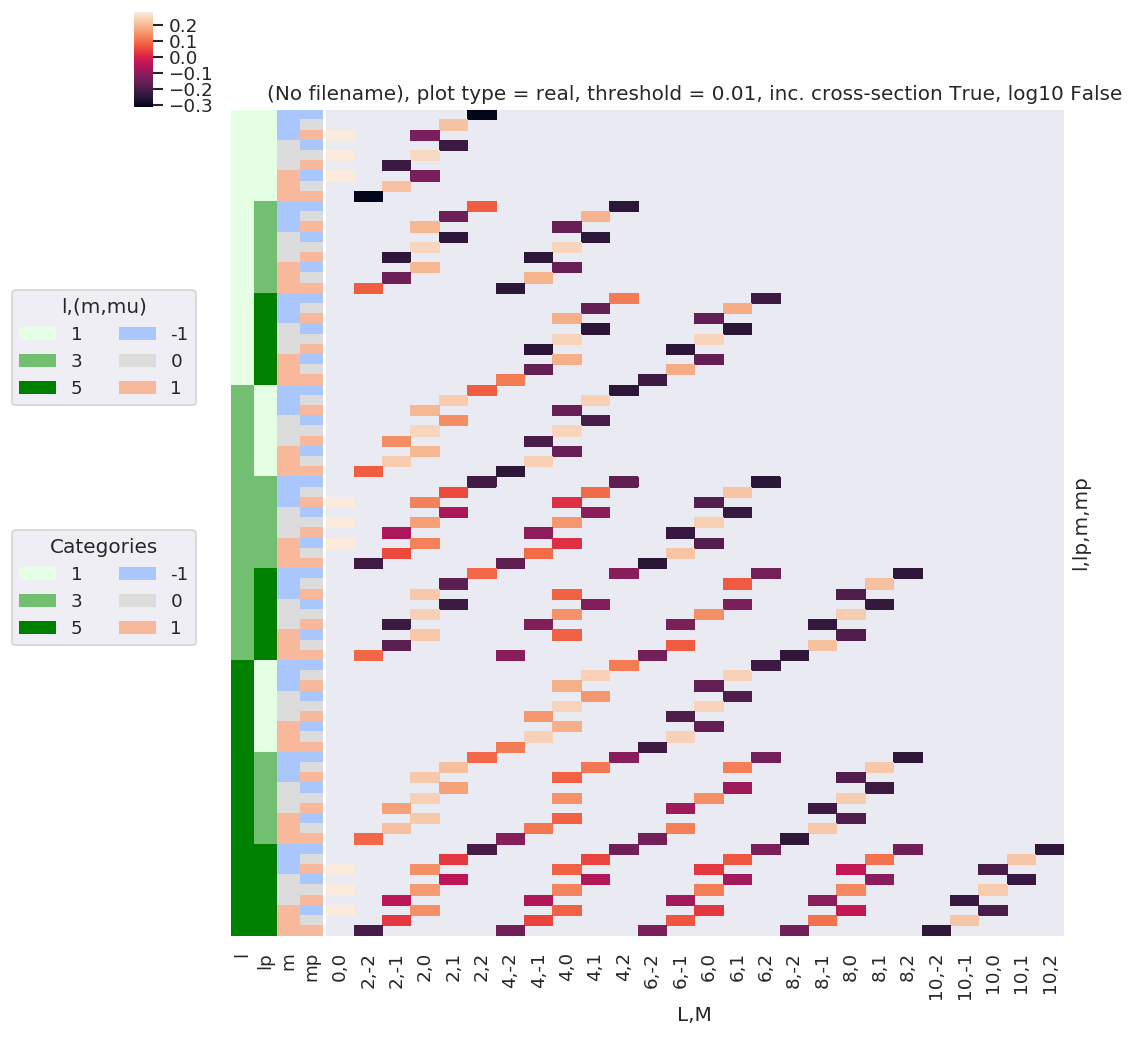

In [27]:
# Plotting - BLMtable
xDimLM = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtable, xDim=xDimLM, pType = 'r')
daPlotpd

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


L                 0         2                                           \
M                  0        -2        -1         0         1         2   
l lp m  mp                                                               
1 1  -1 -1       NaN       NaN       NaN       NaN       NaN -0.309019   
         0       NaN       NaN       NaN       NaN  0.218510       NaN   
         1  0.282095       NaN       NaN -0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.218510       NaN   
         0  0.282095       NaN       NaN  0.252313       NaN       NaN   
         1       NaN       NaN -0.218510       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN -0.126157       NaN       NaN   
         0       NaN       NaN  0.218510       NaN       NaN       NaN   
         1       NaN -0.309019       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN -0.143048       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.233597       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN -0.233597       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN -0.143048       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
3 1  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN  0.233597       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN  0.143048       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN  0.143048       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN  0.233597       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN -0.206013   
         0       NaN       NaN       NaN       NaN  0.059471       NaN   
         1  0.282095       NaN       NaN  0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.059471       NaN   
         0  0.282095       NaN       NaN  0.168209       NaN       NaN   
         1       NaN       NaN -0.059471       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN  0.126157       NaN       NaN   
         0       NaN       NaN  0.059471       NaN       NaN       NaN   
         1       NaN -0.206013       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN  0.092802   
         0       NaN       NaN       NaN       NaN -0.169433       NaN   
         1       NaN       NaN       NaN  0.227318       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.214318       NaN   
         0       NaN       NaN       NaN  0.239615       NaN       NaN   
         1       NaN       NaN -0.214318       NaN       NaN       NaN   
    

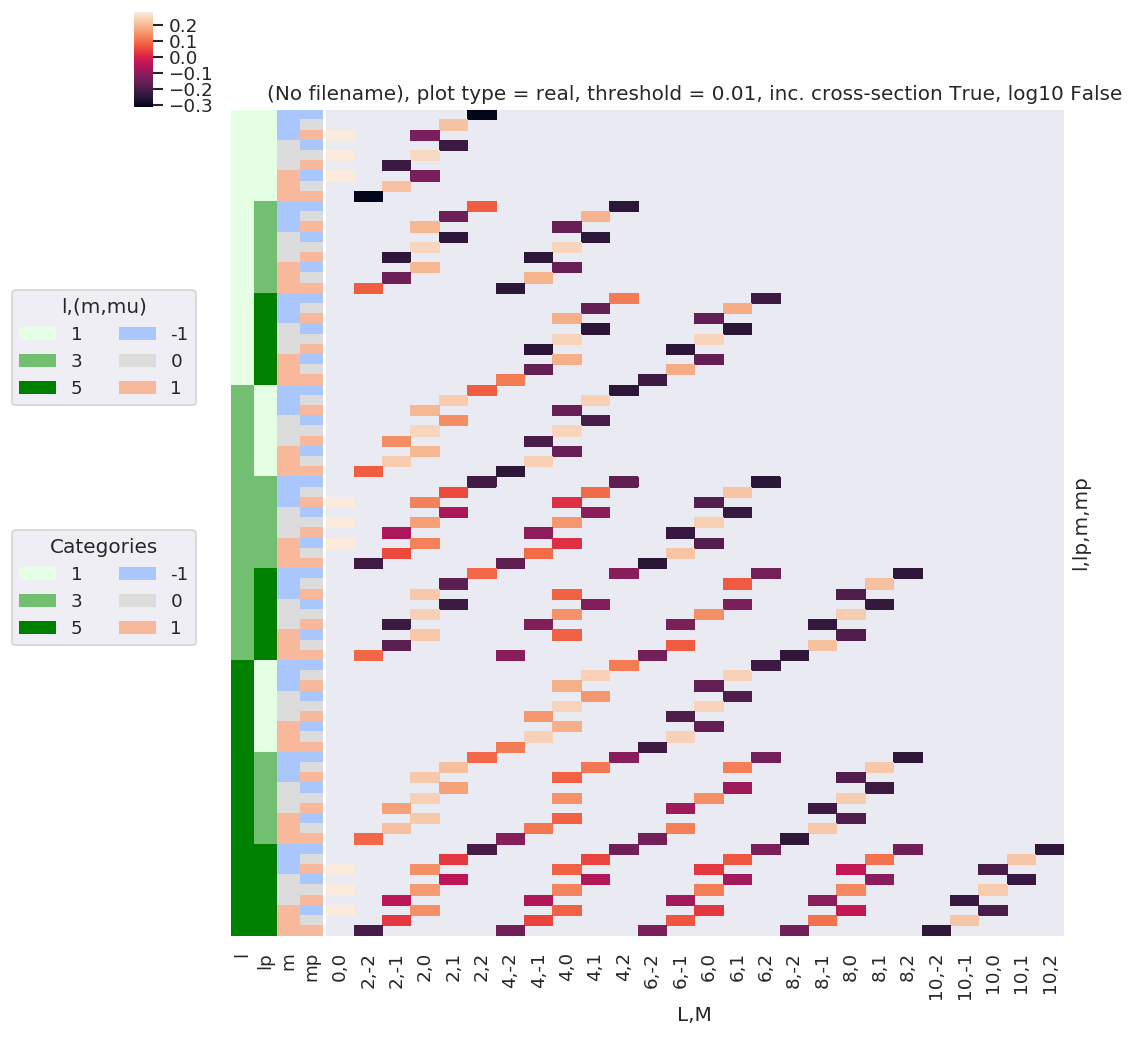

In [28]:
# Plotting - BLMtableResort
xDimLM = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtableResort, xDim=xDimLM, pType = 'r')
daPlotpd

In [29]:
# Check complex values...

BLMtableResortpd, _ = ep.util.multiDimXrToPD(BLMtableResort, colDims=xDimLM, thres = 1e-6)
BLMtableResortpd

L                 0         2                                           \
M                  0        -2        -1         0         1         2   
l lp m  mp                                                               
1 1  -1 -1       NaN       NaN       NaN       NaN       NaN -0.309019   
         0       NaN       NaN       NaN       NaN  0.218510       NaN   
         1  0.282095       NaN       NaN -0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.218510       NaN   
         0  0.282095       NaN       NaN  0.252313       NaN       NaN   
         1       NaN       NaN -0.218510       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN -0.126157       NaN       NaN   
         0       NaN       NaN  0.218510       NaN       NaN       NaN   
         1       NaN -0.309019       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN -0.143048       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.233597       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN -0.233597       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN -0.143048       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
3 1  -1 -1       NaN       NaN       NaN       NaN       NaN  0.082589   
         0       NaN       NaN       NaN       NaN  0.233597       NaN   
         1       NaN       NaN       NaN  0.202301       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN  0.143048       NaN   
         0       NaN       NaN       NaN  0.247767       NaN       NaN   
         1       NaN       NaN  0.143048       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN  0.202301       NaN       NaN   
         0       NaN       NaN  0.233597       NaN       NaN       NaN   
         1       NaN  0.082589       NaN       NaN       NaN       NaN   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN -0.206013   
         0       NaN       NaN       NaN       NaN  0.059471       NaN   
         1  0.282095       NaN       NaN  0.126157       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.059471       NaN   
         0  0.282095       NaN       NaN  0.168209       NaN       NaN   
         1       NaN       NaN -0.059471       NaN       NaN       NaN   
      1 -1  0.282095       NaN       NaN  0.126157       NaN       NaN   
         0       NaN       NaN  0.059471       NaN       NaN       NaN   
         1       NaN -0.206013       NaN       NaN       NaN       NaN   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN  0.092802   
         0       NaN       NaN       NaN       NaN -0.169433       NaN   
         1       NaN       NaN       NaN  0.227318       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN -0.214318       NaN   
         0       NaN       NaN       NaN  0.239615       NaN       NaN   
         1       NaN       NaN -0.214318       NaN       NaN       NaN   
    

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


L                 0                                                 2   \
M                 -2        -1         0         1         2        -2   
l lp m  mp                                                               
1 1  -1 -1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         0 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
      0 -1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         0 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
      1 -1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         0 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
         1 -0.577350 -0.577350 -0.577350 -0.577350 -0.577350  0.365148   
  3  -1 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
      0 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
      1 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
         0       NaN       NaN       NaN       NaN       NaN       NaN   
         1       NaN       NaN       NaN       NaN       NaN       NaN   
3 1  -1 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
      0 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
      1 -1       NaN       NaN       NaN       NaN       NaN -0.292770   
         0       NaN       NaN       NaN       NaN       NaN -0.292770   
         1       NaN       NaN       NaN       NaN       NaN -0.292770   
  3  -1 -1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         0 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
      0 -1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         0 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
      1 -1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         0 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
         1 -0.377964 -0.377964 -0.377964 -0.377964 -0.377964  0.195180   
  5  -1 -1       NaN       NaN       NaN       NaN       NaN -0.208063   
         0       NaN       NaN       NaN       NaN       NaN -0.208063   
         1       NaN       NaN       NaN       NaN       NaN -0.208063   
      0 -1       NaN       NaN       NaN       NaN       NaN -0.208063   
         0       NaN       NaN       NaN       NaN       NaN -0.208063   
         1       NaN       NaN       NaN       NaN       NaN -0.208063   
    

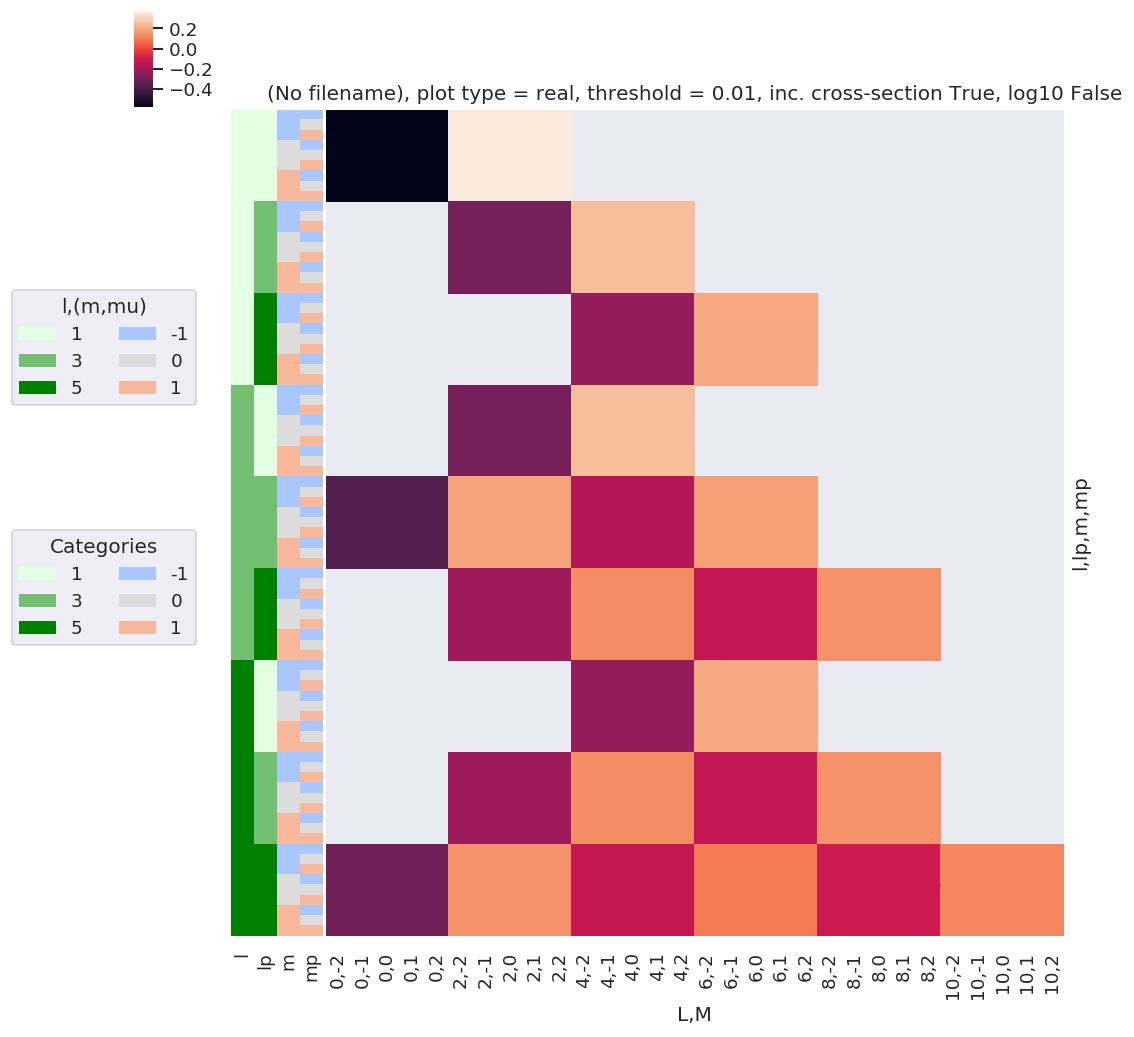

In [30]:
# Double check multiplication over dims - this should have values which are only (l,lp,L) dependent
# **** THIS WORKS, but note some invalid (L,M) terms here - might be an issue later...?
# ACTUALLY - these will drop as NaNs in real case (as above) from BLMtable term.
multTest = xr.ones_like(BLMtable).unstack()*thrj0.drop('mSet').squeeze().unstack()
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(multTest, xDim={'LM':['L','M']}, pType = 'r')
daPlotpd

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=None, with Seaborn


L            0    2                        3              4   ...   8        \
M             0   -2   -1    0    1    2   -1    0    1   -2  ...   -2   -1   
l lp m  mp                                                    ...             
1 1  -1 -1  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  0.0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      0 -1  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  0.0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      1 -1  0.0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
  3  -1 -1  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      0 -1  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      1 -1  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...  NaN  NaN   
  5  -1 -1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      0 -1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      1 -1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...  NaN  NaN   
3 1  -1 -1  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      0 -1  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
      1 -1  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...  NaN  NaN   
  3  -1 -1  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  ...  NaN  NaN   
         1  0.0  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  NaN  ...  NaN  NaN   
      0 -1  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  ...  NaN  NaN   
         0  0.0  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  ...  NaN  NaN   
      1 -1  0.0  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  0.0  NaN  NaN  NaN  0.0  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...  NaN  NaN   
  5  -1 -1  NaN  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
         1  NaN  NaN  NaN  0.0  NaN  NaN  NaN  NaN

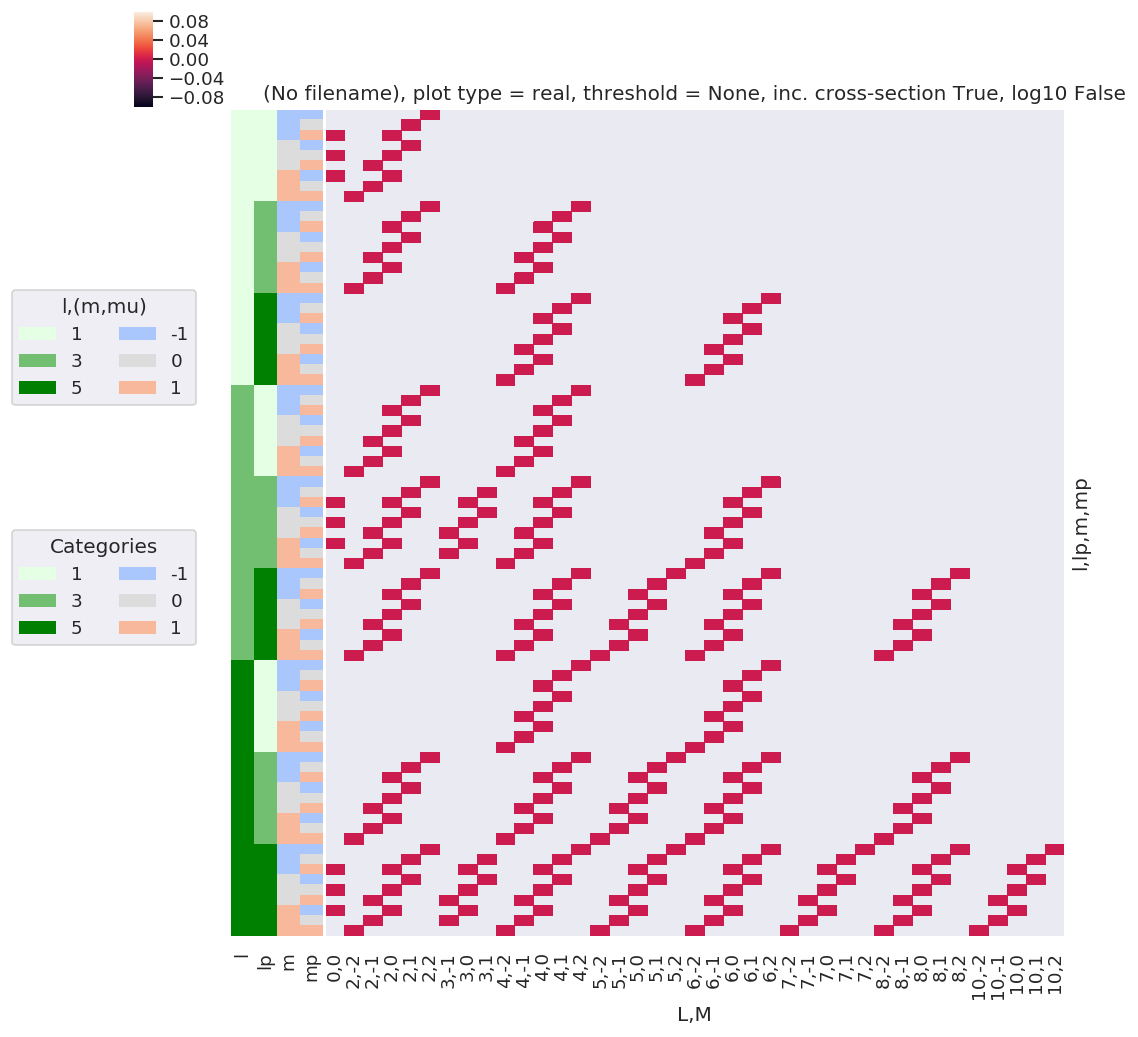

In [31]:
# Check vs. pkg version
diff = BLMtableResortFn - BLMtableResort
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(diff, xDim={'LM':['L','M']}, pType = 'r', thres = None)
daPlotpd
# diff.max()  # All zeros, plotting fails!

## Matrix element products

**Without Sym sum - get all cross-terms within each symmetry set {Targ,Total,Cont}**

In [32]:
# Use matEthres set earlier, or reset here...
matEthres = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'it':1, 'Type':'L'})

#*** Products
# Matrix element pair-wise multiplication by (l,m,mu) dims
matEconj = matEthres.copy().conj()
matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})
matEmult = matEthres.unstack() * matEconj
matEmult.attrs['dataType'] = 'multTest'

# Threshold product and drop dims.
# matEmult = ep.util.matEleSelector(matEmult, thres = thres, dims = thresDims)
matEmult = matEleSelector(matEmult, thres = thres, dims = thresDims)

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


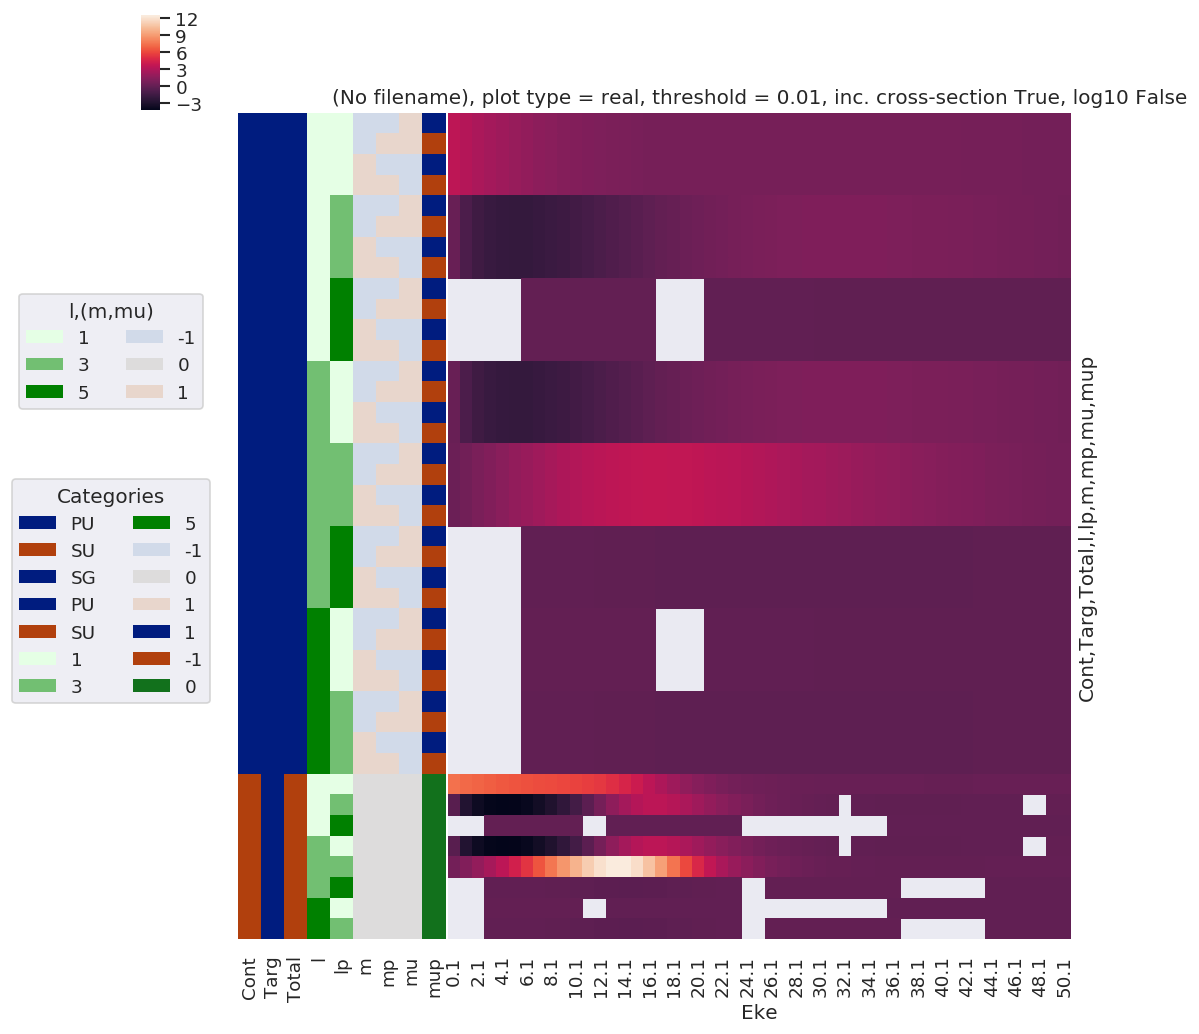

In [33]:
# Plot vs. Eke
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult, pType = 'r')

In [34]:
# Check complex values...
matEmultpd, _ = ep.util.multiDimXrToPD(matEmult, colDims='Eke', thres = 1e-6)
matEmultpd

Eke                                              0.1                 1.1   \
Cont Targ Total l lp m  mp mu mup                                           
PU   SG   PU    1 1  -1 -1  1  1   3.556042+0.000000j  3.184853+0.000000j   
                         1  1 -1   3.556042+0.000000j  3.184853+0.000000j   
                      1 -1 -1  1   3.556042+0.000000j  3.184853+0.000000j   
                         1 -1 -1   3.556042+0.000000j  3.184853+0.000000j   
                  3  -1 -1  1  1   0.248403+1.117117j -0.910539+1.106370j   
                         1  1 -1   0.248403+1.117117j -0.910539+1.106370j   
                      1 -1 -1  1   0.248403+1.117117j -0.910539+1.106370j   
                         1 -1 -1   0.248403+1.117117j -0.910539+1.106370j   
                  5  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                3 1  -1 -1  1  1   0.248403-1.117117j -0.910539-1.106370j   
                         1  1 -1   0.248403-1.117117j -0.910539-1.106370j   
                      1 -1 -1  1   0.248403-1.117117j -0.910539-1.106370j   
                         1 -1 -1   0.248403-1.117117j -0.910539-1.106370j   
                  3  -1 -1  1  1   0.368290+0.000000j  0.644656+0.000000j   
                         1  1 -1   0.368290+0.000000j  0.644656+0.000000j   
                      1 -1 -1  1   0.368290+0.000000j  0.644656+0.000000j   
                         1 -1 -1   0.368290+0.000000j  0.644656+0.000000j   
                  5  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                5 1  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                  3  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
SU   SG   SU    1 1   0  0  0  0   7.496043+0.000000j  7.214930+0.000000j   
                  3   0  0  0  0  -0.395799+2.192079j -2.680473+1.300392j   
                  5   0  0  0  0                  NaN                 NaN   
                3 1   0  0  0  0  -0.395799-2.192079j -2.680473-1.300392j   
                  3   0  0  0  0   0.661931+0.000000j  1.230221+0.000000j   
                  5   0  0  0  0                  NaN                 NaN   
                5 1   0  0  0  0                  NaN                 NaN   
                  3   0  0  0  0                  NaN                 NaN   

Eke                                              2.1                 3.1   \
Cont Targ Total l lp m  mp mu mup                                           
PU   SG   PU    1 1  -1 -1  1  1   2.857544+0.000000j  2.565479+0.000000j   
                         1  1 -1   2.857544+0.000000j  2.565479+0.000000j   
                      1 -1 -1  1   2.857544+0.000000j  2.565479+0.000000j   
                         1 -1 -1   2.857544+0.000000j  2.565479+0.000000j   
                  3  -1 -1  1  1  -1.449628+0.762223j -1.742309+0.380828j   
                         1  1 -1  -1.449628+0.762223j -1.742309+0.380828j   
                      1 -1 -1  1  -1.449628+0.762223j -1.742309+0.380828j   
                         1 -1 -1  -1.449628+0.762223j -1.742309+0.380828

**With Sym sum - get all cross-terms**

In [35]:
# if symSum:
#     if 'Sym' in matE.dims:
#         matE = matE.sum('Sym')

matESsym = matEthres.sum('Sym')
        
#*** Products
# Matrix element pair-wise multiplication by (l,m,mu) dims
matESsymconj = matESsym.copy().conj()
matESsymconj = matESsymconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})
matEmultSsym = matESsym.unstack() * matESsymconj
matEmultSsym.attrs['dataType'] = 'multTest'

# Threshold product and drop dims.
# matEmult = ep.util.matEleSelector(matEmult, thres = thres, dims = thresDims)
matEmultSsym = matEleSelector(matEmultSsym, thres = thres, dims = thresDims)

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


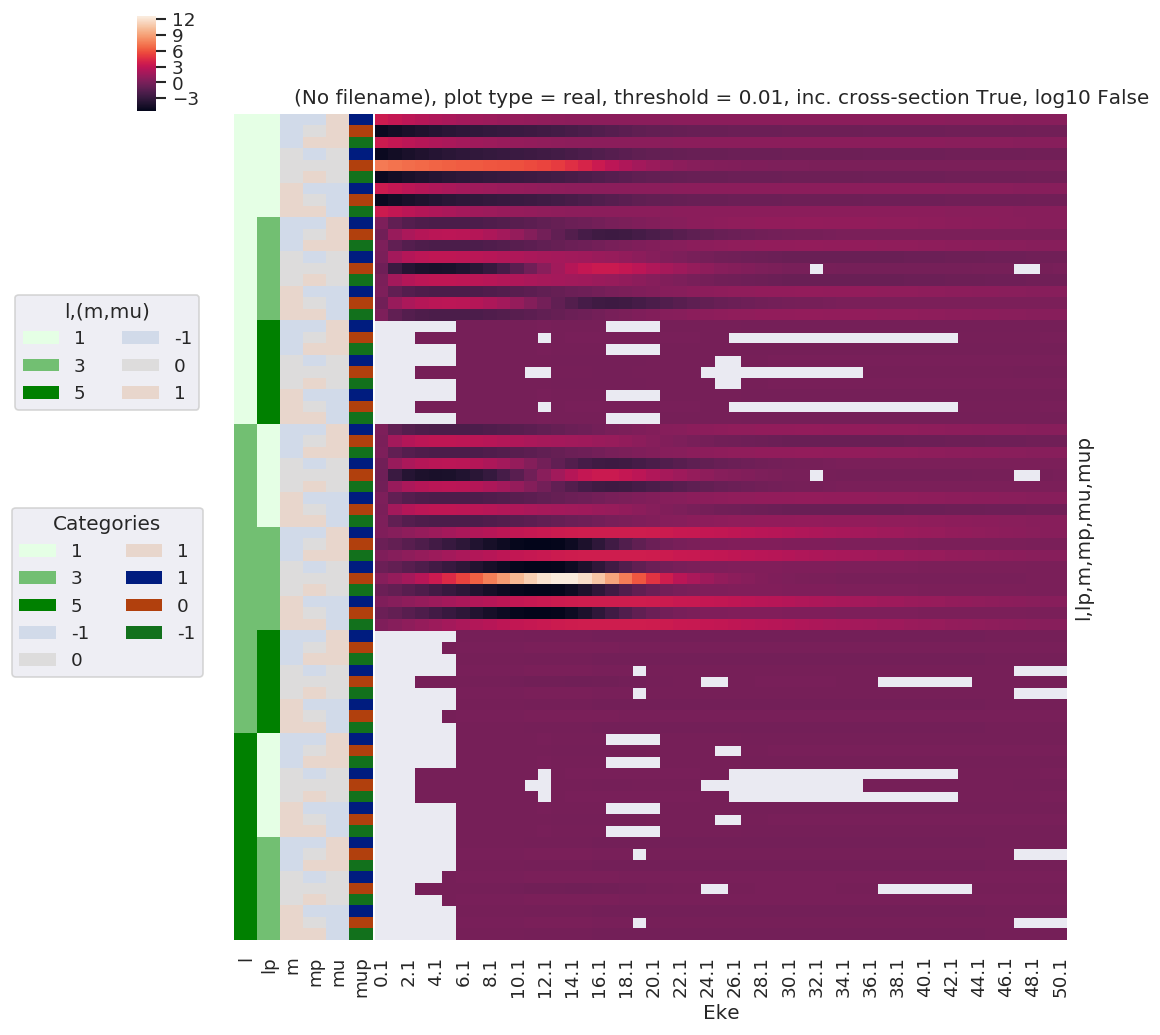

In [36]:
# Plot vs. Eke
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmultSsym, pType = 'r')

In [37]:
# Check complex values...
matEmultpd, _ = ep.util.multiDimXrToPD(matEmultSsym, colDims='Eke', thres = 1e-6)
matEmultpd

Eke                              0.1                 1.1                 2.1   \
l lp m  mp mu mup                                                               
1 1  -1 -1  1  1   3.556042+0.000000j  3.184853+0.000000j  2.857544+0.000000j   
         0  1  0  -4.917744+1.572271j -4.533884+1.556403j -4.206751+1.511601j   
         1  1 -1   3.556042+0.000000j  3.184853+0.000000j  2.857544+0.000000j   
      0 -1  0  1  -4.917744-1.572271j -4.533884-1.556403j -4.206751-1.511601j   
         0  0  0   7.496043+0.000000j  7.214930+0.000000j  6.992610+0.000000j   
         1  0 -1  -4.917744-1.572271j -4.533884-1.556403j -4.206751-1.511601j   
      1 -1 -1  1   3.556042+0.000000j  3.184853+0.000000j  2.857544+0.000000j   
         0 -1  0  -4.917744+1.572271j -4.533884+1.556403j -4.206751+1.511601j   
         1 -1 -1   3.556042+0.000000j  3.184853+0.000000j  2.857544+0.000000j   
  3  -1 -1  1  1   0.248403+1.117117j -0.910539+1.106370j -1.449628+0.762223j   
         0  1  0  -0.200120-1.521120j  1.403897-1.395401j  2.168012-0.846819j   
         1  1 -1   0.248403+1.117117j -0.910539+1.106370j -1.449628+0.762223j   
      0 -1  0  1   0.150399-1.654720j  1.836893-1.130033j  2.537284-0.355278j   
         0  0  0  -0.395799+2.192079j -2.680473+1.300392j -3.639608+0.099802j   
         1  0 -1   0.150399-1.654720j  1.836893-1.130033j  2.537284-0.355278j   
      1 -1 -1  1   0.248403+1.117117j -0.910539+1.106370j -1.449628+0.762223j   
         0 -1  0  -0.200120-1.521120j  1.403897-1.395401j  2.168012-0.846819j   
         1 -1 -1   0.248403+1.117117j -0.910539+1.106370j -1.449628+0.762223j   
  5  -1 -1  1  1                  NaN                 NaN                 NaN   
         0  1  0                  NaN                 NaN                 NaN   
         1  1 -1                  NaN                 NaN                 NaN   
      0 -1  0  1                  NaN                 NaN                 NaN   
         0  0  0                  NaN                 NaN                 NaN   
         1  0 -1                  NaN                 NaN                 NaN   
      1 -1 -1  1                  NaN                 NaN                 NaN   
         0 -1  0                  NaN                 NaN                 NaN   
         1 -1 -1                  NaN                 NaN                 NaN   
3 1  -1 -1  1  1   0.248403-1.117117j -0.910539-1.106370j -1.449628-0.762223j   
         0  1  0   0.150399+1.654720j  1.836893+1.130033j  2.537284+0.355278j   
         1  1 -1   0.248403-1.117117j -0.910539-1.106370j -1.449628-0.762223j   
      0 -1  0  1  -0.200120+1.521120j  1.403897+1.395401j  2.168012+0.846819j   
         0  0  0  -0.395799-2.192079j -2.680473-1.300392j -3.639608-0.099802j   
         1  0 -1  -0.200120+1.521120j  1.403897+1.395401j  2.168012+0.846819j   
      1 -1 -1  1   0.248403-1.117117j -0.910539-1.106370j -1.449628-0.762223j   
         0 -1  0   0.150399+1.654720j  1.836893+1.130033j  2.537284+0.355278j   
         1 -1 -1   0.248403-1.117117j -0.910539-1.106370j -1.449628-0.762223j   
  3  -1 -1  1  1   0.368290+0.000000j  0.644656+0.000000j  0.938710+0.000000j   
         0  1  0  -0.491833-0.043389j -0.886111-0.088752j -1.325711-0.148706j   
         1  1 -1   0.368290+0.000000j  0.644656+0.000000j  0.938710+0.000000j   
      0 -1  0  1  -0.491833+0.043389j -0.886111+0.088752j -1.325711+0.148706j   
         0  0  0   0.661931+0.000000j  1.230221+0.000000j  1.895817+0.000000j   
         1  0 -1  -0.491833+0.043389j -0.886111+0.088752j -1.325711+0.148706j   
      1 -1 -1  1   0.368290+0.000000j  0.644656+0.000000j  0.938710+0.000000j   
         0 -1  0  -0.491833-0.043389j -0.886111-0.088752j -1.325711-0.148706j   
         1 -1 -1   0.368290+0.000000j  0.644656+0.000000j  0.938710+0.000000j   
  5  -1 -1  1  1                  NaN                 NaN                 NaN   
         0  1  0                  NaN                 NaN                 NaN   
         1  1 -1               

************************ **TEST: Without Sym Unstacking**

In [38]:
# Use matEthres set earlier, or reset here...
matEthres = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'it':1, 'Type':'L'})

#*** Products
# Matrix element pair-wise multiplication by (l,m,mu) dims
matEconj = matEthres.copy().conj()
matEconj = matEconj.unstack('LM').rename({'l':'lp','m':'mp','mu':'mup'})
matEmult = matEthres.unstack('LM') * matEconj
matEmult.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.

# Threshold product and drop dims.
# matEmult = ep.util.matEleSelector(matEmult, thres = thres, dims = thresDims)
matEmult = matEleSelector(matEmult, thres = thres, dims = thresDims)

Plotting data (No filename), pType=a, thres=0.01, with Seaborn
Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=a, thres=0.01, with Seaborn


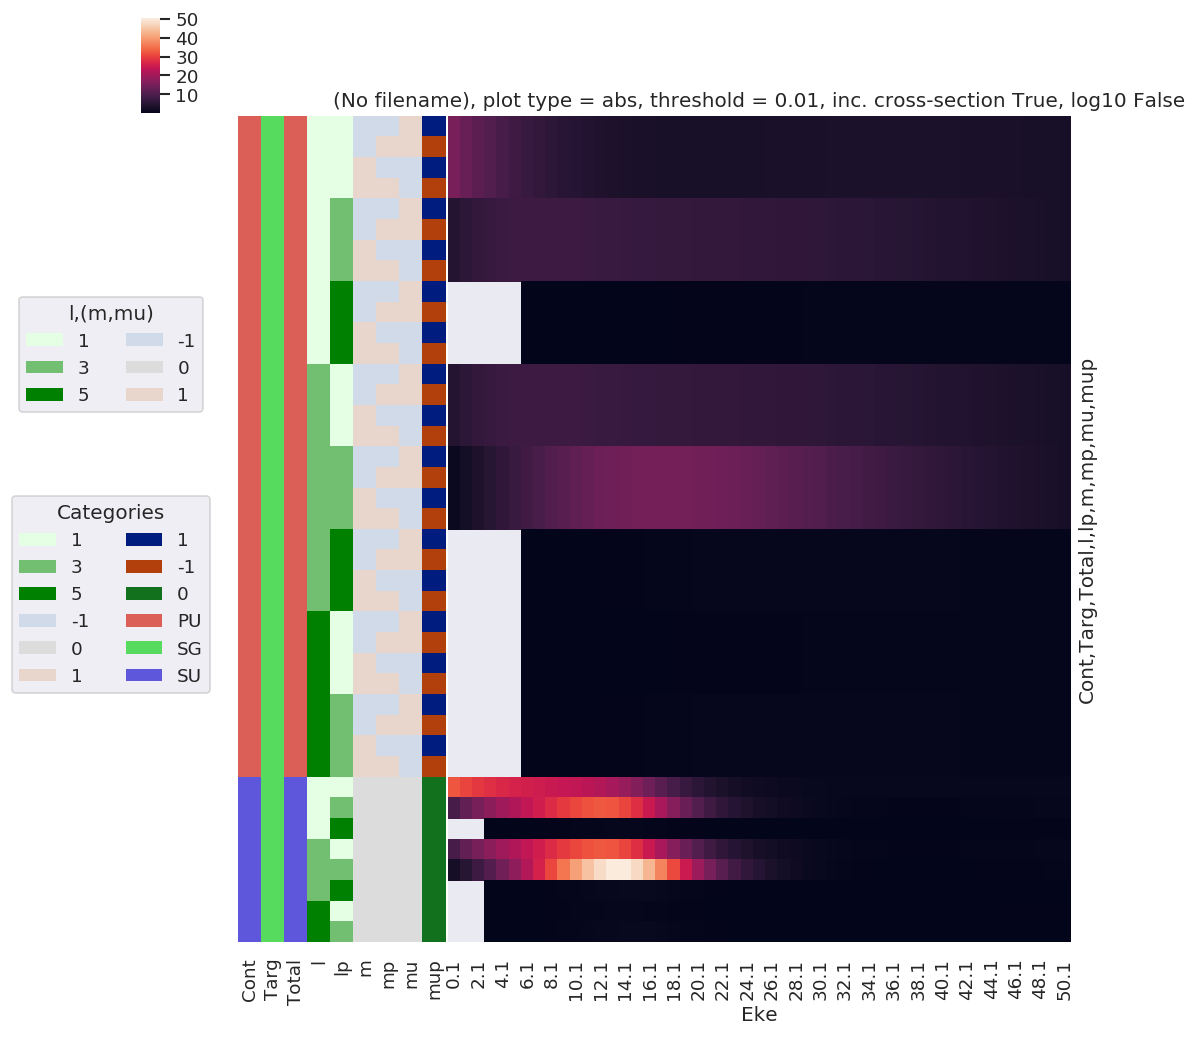

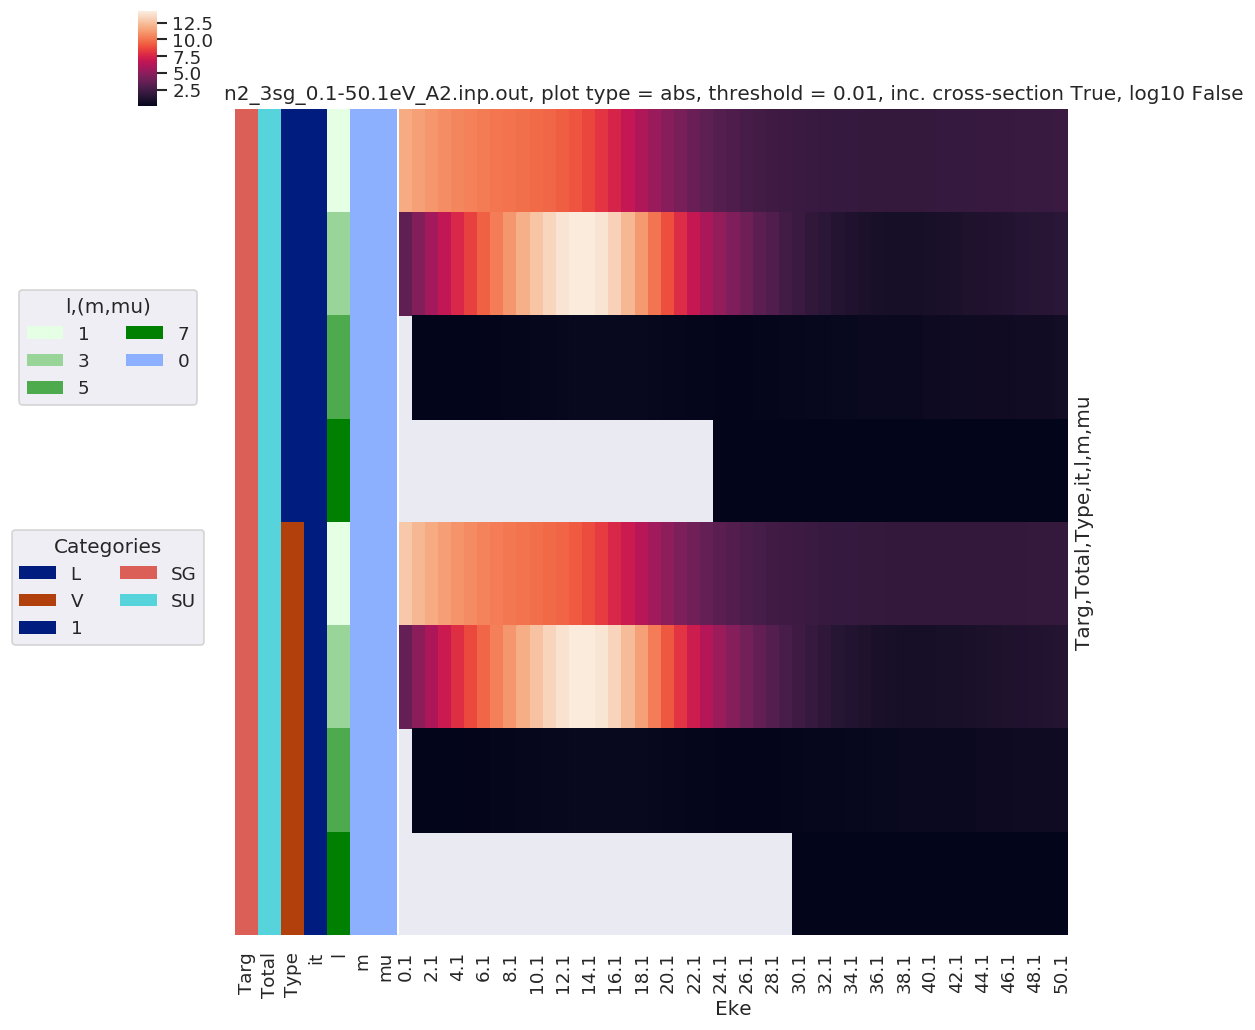

In [39]:
# Plot vs. Eke
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult, pType = 'a')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, pType = 'a')  # Compare with original set

In [40]:
# Check complex values...
matEmultpd, _ = ep.util.multiDimXrToPD(matEmult, colDims='Eke', thres = 1e-6)
matEmultpd

Eke                                              0.1                 1.1   \
Cont Targ Total l lp m  mp mu mup                                           
PU   SG   PU    1 1  -1 -1  1  1   3.556042+0.000000j  3.184853+0.000000j   
                         1  1 -1   3.556042+0.000000j  3.184853+0.000000j   
                      1 -1 -1  1   3.556042+0.000000j  3.184853+0.000000j   
                         1 -1 -1   3.556042+0.000000j  3.184853+0.000000j   
                  3  -1 -1  1  1   0.248403+1.117117j -0.910539+1.106370j   
                         1  1 -1   0.248403+1.117117j -0.910539+1.106370j   
                      1 -1 -1  1   0.248403+1.117117j -0.910539+1.106370j   
                         1 -1 -1   0.248403+1.117117j -0.910539+1.106370j   
                  5  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                3 1  -1 -1  1  1   0.248403-1.117117j -0.910539-1.106370j   
                         1  1 -1   0.248403-1.117117j -0.910539-1.106370j   
                      1 -1 -1  1   0.248403-1.117117j -0.910539-1.106370j   
                         1 -1 -1   0.248403-1.117117j -0.910539-1.106370j   
                  3  -1 -1  1  1   0.368290+0.000000j  0.644656+0.000000j   
                         1  1 -1   0.368290+0.000000j  0.644656+0.000000j   
                      1 -1 -1  1   0.368290+0.000000j  0.644656+0.000000j   
                         1 -1 -1   0.368290+0.000000j  0.644656+0.000000j   
                  5  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                5 1  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
                  3  -1 -1  1  1                  NaN                 NaN   
                         1  1 -1                  NaN                 NaN   
                      1 -1 -1  1                  NaN                 NaN   
                         1 -1 -1                  NaN                 NaN   
SU   SG   SU    1 1   0  0  0  0   7.496043+0.000000j  7.214930+0.000000j   
                  3   0  0  0  0  -0.395799+2.192079j -2.680473+1.300392j   
                  5   0  0  0  0                  NaN                 NaN   
                3 1   0  0  0  0  -0.395799-2.192079j -2.680473-1.300392j   
                  3   0  0  0  0   0.661931+0.000000j  1.230221+0.000000j   
                  5   0  0  0  0                  NaN                 NaN   
                5 1   0  0  0  0                  NaN                 NaN   
                  3   0  0  0  0                  NaN                 NaN   

Eke                                              2.1                 3.1   \
Cont Targ Total l lp m  mp mu mup                                           
PU   SG   PU    1 1  -1 -1  1  1   2.857544+0.000000j  2.565479+0.000000j   
                         1  1 -1   2.857544+0.000000j  2.565479+0.000000j   
                      1 -1 -1  1   2.857544+0.000000j  2.565479+0.000000j   
                         1 -1 -1   2.857544+0.000000j  2.565479+0.000000j   
                  3  -1 -1  1  1  -1.449628+0.762223j -1.742309+0.380828j   
                         1  1 -1  -1.449628+0.762223j -1.742309+0.380828j   
                      1 -1 -1  1  -1.449628+0.762223j -1.742309+0.380828j   
                         1 -1 -1  -1.449628+0.762223j -1.742309+0.380828

### Mult by BLMterm

**Direct mult**

In [41]:
thres = 1e-3
# matEmult = matEleSelector(matEmult, thres = thres, dims = thresDims)

# Initial notes here for case with incorrect M terms set!  With correction (3/4/20 pm) things seem better.
BLMprod = matEmult * BLMtableResort    # !FOR CASE WITHOUT SYM SUM this keeps sym dims, but most go to NaNs - need different product here? Takes intersection of das - http://xarray.pydata.org/en/stable/computation.html#automatic-alignment
                                      # NOW FIXED - issue was actually upstream M term assignment leading to null case for some syms.
# BLMprod = matEmult.stack({'Sym':['Cont','Targ','Total']}) * BLMtableResort    # Runs, but ugly - seems to give same result as unstacked case, but larger array due to stacking.
# BLMprod = matEmult.unstack('Sym') * BLMtableResort    # Same result - keeps syms in dims, but all NaN along PU dims.
# BLMprod = matEmultSsym * BLMtableResort  # Sym summed case - this seems OK, and keeps all terms (probably)


Plotting data (No filename), pType=r, thres=None, with Seaborn


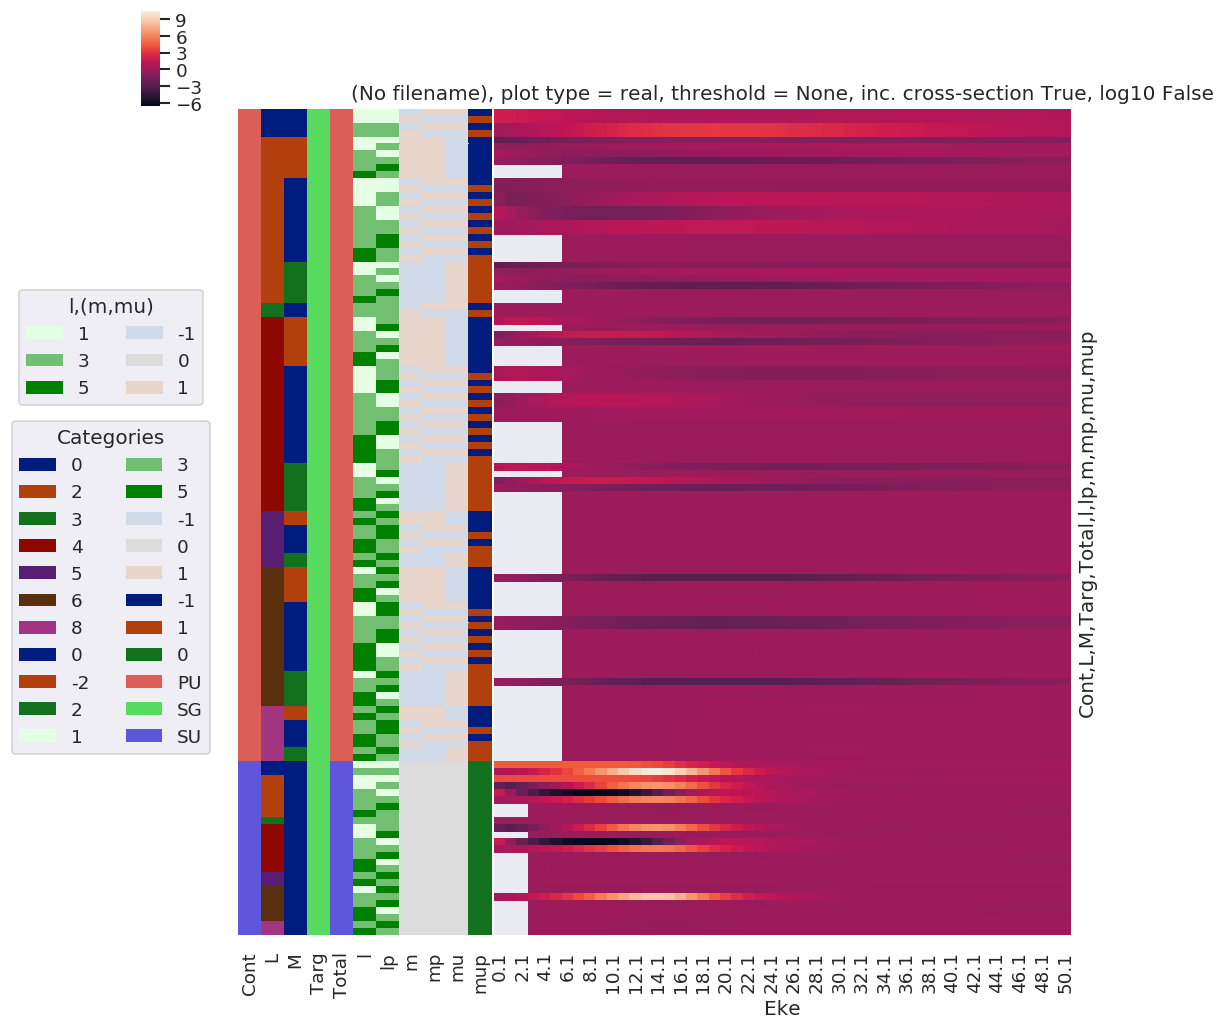

In [42]:
# Plot vs. Eke
BLMprod.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprod, pType = 'r', thres = None)

In [43]:
# Check complex values...
BLMprodpd, _ = ep.util.multiDimXrToPD(BLMprod, colDims='Eke', thres = thres)
BLMprodpd

Eke                                                   0.1   \
Cont L M  Targ Total l lp m  mp mu mup                       
PU   0  0 SG   PU    1 1  -1  1  1 -1   1.003141+0.000000j   
                           1 -1 -1  1   1.003141+0.000000j   
                     3 3  -1  1  1 -1   0.103893+0.000000j   
                           1 -1 -1  1   0.103893+0.000000j   
     2 -2 SG   PU    1 1   1  1 -1 -1  -1.098886+0.000000j   
...                                                    ...   
SU   6  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 1   0  0  0  0                  NaN   
                       3   0  0  0  0                  NaN   
     8  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 3   0  0  0  0                  NaN   

Eke                                                   1.1   \
Cont L M  Targ Total l lp m  mp mu mup                       
PU   0  0 SG   PU    1 1  -1  1  1 -1   0.898431+0.000000j   
                           1 -1 -1  1   0.898431+0.000000j   
                     3 3  -1  1  1 -1   0.181854+0.000000j   
                           1 -1 -1  1   0.181854+0.000000j   
     2 -2 SG   PU    1 1   1  1 -1 -1  -0.984181+0.000000j   
...                                                    ...   
SU   6  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 1   0  0  0  0                  NaN   
                       3   0  0  0  0                  NaN   
     8  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 3   0  0  0  0                  NaN   

Eke                                                   2.1   \
Cont L M  Targ Total l lp m  mp mu mup                       
PU   0  0 SG   PU    1 1  -1  1  1 -1   0.806098+0.000000j   
                           1 -1 -1  1   0.806098+0.000000j   
                     3 3  -1  1  1 -1   0.264805+0.000000j   
                           1 -1 -1  1   0.264805+0.000000j   
     2 -2 SG   PU    1 1   1  1 -1 -1  -0.883037+0.000000j   
...                                                    ...   
SU   6  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 1   0  0  0  0                  NaN   
                       3   0  0  0  0                  NaN   
     8  0 SG   SU    3 5   0  0  0  0                  NaN   
                     5 3   0  0  0  0                  NaN   

Eke                                                   3.1   \
Cont L M  Targ Total l lp m  mp mu mup                       
PU   0  0 SG   PU    1 1  -1  1  1 -1   0.723708+0.000000j   
                           1 -1 -1  1   0.723708+0.000000j   
                     3 3  -1  1  1 -1   0.349740+0.000000j   
                           1 -1 -1  1   0.349740+0.000000j   
     2 -2 SG   PU    1 1   1  1 -1 -1  -0.792783+0.000000j   
...                                                    ...   
SU   6  0 SG   SU    3 5   0  0  0  0  -0.001549-0.001824j   
                     5 1   0  0  0  0   0.002751-0.005845j   
                       3   0  0  0  0  -0.001549+0.001824j   
     8  0 SG   SU    3 5   0  0  0  0  -0.002501-0.002945j   
                     5 3   0  0  0  0  -0.002501+0.002945j   

Eke                                                   4.1   \
Cont L M  Targ Total l lp m  mp mu mup                       
PU   0  0 SG   PU    1 1  -1  1  1 -1   0.649800+0.000000j   
                           1 -1 -1  1   0.649800+0.000000j   
                     3 3  -1  1  1 -1   0.435059+0.000000j   
                           1 -1 -1  1   0.435059+0.000000j   
     2 -2 SG   PU    1 1   1  1 -1 -1  -0.711820+0.000000j   
...                                                    ...   
SU   6  0 SG   SU    3 5   0  0  0  0  -0.002519-0.002384j   
                     5 1   0  0  0  0   0.002546-0.007651j   
                       3   0  0  0  0  -0.002519+0.002384j   
     8  0 SG   SU    3 5   0  0  0  0  -0.004067-0.003849j   
                     5 3   0

**CONCLUSION** Seems to be working OK/as expected for N2 test case, now that M term assignment is fixed (otherwise knocked out PU symmetry group).  These results *look* OK, but details likely still incorrect.

**What about sym summed case...**

In [44]:
# Test symSummed case for comparison
BLMprodSsym = matEmultSsym * BLMtableResort  # Sym summed case - includes cross-terms over symmetries.

Plotting data (No filename), pType=r, thres=0.001, with Seaborn


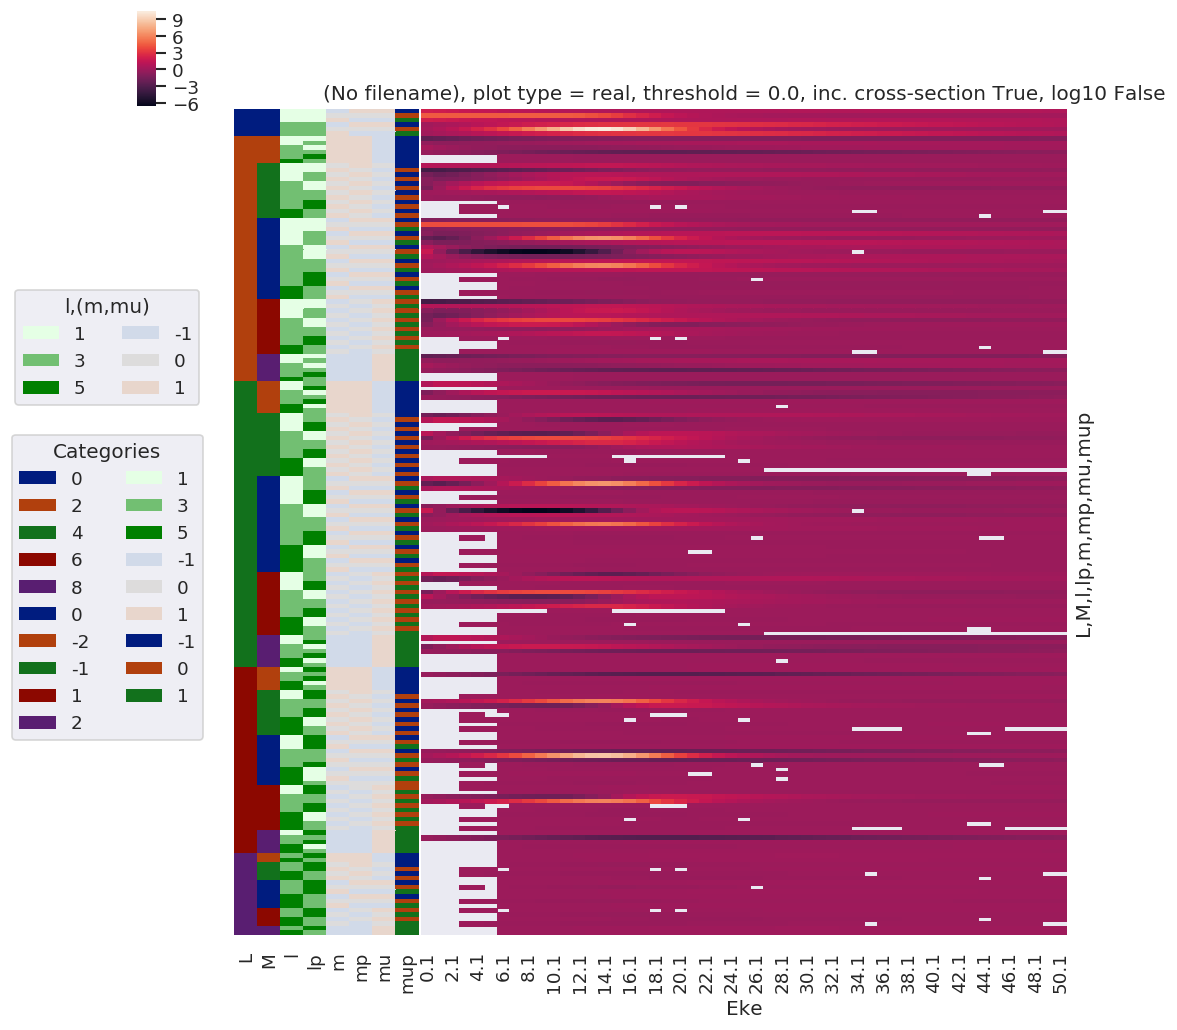

In [45]:
# Plot vs. Eke
BLMprodSsym.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprodSsym, pType = 'r', thres = thres)

In [46]:
# Check complex values...
BLMprodSsympd, _ = ep.util.multiDimXrToPD(BLMprodSsym, colDims='Eke', thres = thres)
BLMprodSsympd

Eke                                  0.1                 1.1   \
L M l lp m  mp mu mup                                           
0 0 1 1  -1  1  1 -1   1.003141+0.000000j  0.898431+0.000000j   
          0  0  0  0   2.114595+0.000000j  2.035294+0.000000j   
          1 -1 -1  1   1.003141+0.000000j  0.898431+0.000000j   
    3 3  -1  1  1 -1   0.103893+0.000000j  0.181854+0.000000j   
          0  0  0  0   0.186727+0.000000j  0.347039+0.000000j   
...                                   ...                 ...   
8 1 3 5   0 -1  0  1                  NaN                 NaN   
    5 3  -1  0  1  0                  NaN                 NaN   
          0 -1  0  1                  NaN                 NaN   
  2 3 5  -1 -1  1  1                  NaN                 NaN   
    5 3  -1 -1  1  1                  NaN                 NaN   

Eke                                  2.1                 3.1   \
L M l lp m  mp mu mup                                           
0 0 1 1  -1  1  1 -1   0.806098+0.000000j  0.723708+0.000000j   
          0  0  0  0   1.972579+0.000000j  1.920430+0.000000j   
          1 -1 -1  1   0.806098+0.000000j  0.723708+0.000000j   
    3 3  -1  1  1 -1   0.264805+0.000000j  0.349740+0.000000j   
          0  0  0  0   0.534800+0.000000j  0.746982+0.000000j   
...                                   ...                 ...   
8 1 3 5   0 -1  0  1                  NaN                 NaN   
    5 3  -1  0  1  0                  NaN                 NaN   
          0 -1  0  1                  NaN -0.001327+0.002034j   
  2 3 5  -1 -1  1  1                  NaN                 NaN   
    5 3  -1 -1  1  1                  NaN                 NaN   

Eke                                  4.1                 5.1   \
L M l lp m  mp mu mup                                           
0 0 1 1  -1  1  1 -1   0.649800+0.000000j  0.583519+0.000000j   
          0  0  0  0   1.875290+0.000000j  1.835273+0.000000j   
          1 -1 -1  1   0.649800+0.000000j  0.583519+0.000000j   
    3 3  -1  1  1 -1   0.435059+0.000000j  0.519460+0.000000j   
          0  0  0  0   0.983322+0.000000j  1.244132+0.000000j   
...                                   ...                 ...   
8 1 3 5   0 -1  0  1                  NaN                 NaN   
    5 3  -1  0  1  0                  NaN                 NaN   
          0 -1  0  1  -0.002121+0.002684j -0.003313+0.003316j   
  2 3 5  -1 -1  1  1                  NaN                 NaN   
    5 3  -1 -1  1  1                  NaN                 NaN   

Eke                                  6.1                 7.1   \
L M l lp m  mp mu mup                                           
0 0 1 1  -1  1  1 -1   0.524332+0.000000j  0.471856+0.000000j   
          0  0  0  0   1.799321+0.000000j  1.766494+0.000000j   
          1 -1 -1  1   0.524332+0.000000j  0.471856+0.000000j   
    3 3  -1  1  1 -1   0.601561+0.000000j  0.679880+0.000000j   
          0  0  0  0   1.529194+0.000000j  1.836939+0.000000j   
...                                   ...                 ...   
8 1 3 5   0 -1  0  1  -0.006048-0.001919j -0.008511-0.001133j   
    5 3  -1  0  1  0   0.006048-0.001919j  0.008511-0.001133j   
          0 -1  0  1  -0.004967+0.003937j -0.007133+0.004584j   
  2 3 5  -1 -1  1  1   0.003610+0.001984j  0.005055+0.001919j   
    5 3  -1 -1  1  1   0.003610-0.001984j  0.005055-0.001919j   

Eke                                  8.1                 9.1   ...  \
L M l lp m  mp mu mup                                          ...   
0 0 1 1  -1  1  1 -1   0.425754+0.000000j  0.385683+0.000000j  ...   
          0  0  0  0   1.735332+0.000000j  1.703232+0.000000j  ...   
          1 -1 -1  1   0.425754+0.000000j  0.385683+0.000000j  ...   
    3 3  -1  1  1 -1   0.752945+0.000000j  0.819438+0.000000j  ...   
          0  0  0  0   2.163385+0.000000j  2.500476+0.000000j  ...   
...                                   ...                 ...  ...   
8 1 3 5   0 -1  0  1  -0.011520+0.000369j -0.014982+0.00

## Final product

### Without sym sum

In [47]:
# Multiplication term polProd * BLMprod

# Phase & p-summation - already set above
# if phaseCons['mfblmCons']['mupPhase']:
#     mupPhaseTerm = np.power(-1, np.abs(polProd.mup - polProd.p))
#     polProd *= mupPhaseTerm

# polProd = polProd.sum(sumDimsPol)

# Test big mult...
# mTerm = polProd.sel({'R':0,'Labels':'z'}) * BLMprod.sum(['Total'])    # With selection of z geom.  # BLMprod.sum(['Cont', 'Targ', 'Total'])
# mTerm = polProd.sel({'R':0}) * BLMprod    # BLMprod.sum(['Cont', 'Targ', 'Total'])
mTerm = polProd * BLMprod

In [48]:
# Quite slow - mainly in restack and selection?  mTerm.size=10^7
# Plot vs. Eke
# mTerm.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTerm, pType = 'r', thres = thres)

# PLOT BEFORE SUMMATION - shows (x,y,z) differences, but non-zero for all terms???

In [49]:
# Check complex values...
BLMprodSsympd, _ = ep.util.multiDimXrToPD(mTerm, colDims='Eke', thres = thres)
BLMprodSsympd

Eke                                                             0.1   \
Cont L Labels M R-p Targ Total l lp m  mp mu mup                       
PU   0 x      0 -1  SG   PU    1 1  -1  1  1 -1   0.354664+0.000000j   
                                     1 -1 -1  1  -0.354664+0.000000j   
                               3 3  -1  1  1 -1   0.036732+0.000000j   
                                     1 -1 -1  1  -0.036732+0.000000j   
                 0  SG   PU    1 1  -1  1  1 -1   0.501570+0.000000j   
...                                                              ...   
SU   6 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 1   0  0  0  0                  NaN   
                                 3   0  0  0  0                  NaN   
     8 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 3   0  0  0  0                  NaN   

Eke                                                             1.1   \
Cont L Labels M R-p Targ Total l lp m  mp mu mup                       
PU   0 x      0 -1  SG   PU    1 1  -1  1  1 -1   0.317643+0.000000j   
                                     1 -1 -1  1  -0.317643+0.000000j   
                               3 3  -1  1  1 -1   0.064295+0.000000j   
                                     1 -1 -1  1  -0.064295+0.000000j   
                 0  SG   PU    1 1  -1  1  1 -1   0.449215+0.000000j   
...                                                              ...   
SU   6 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 1   0  0  0  0                  NaN   
                                 3   0  0  0  0                  NaN   
     8 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 3   0  0  0  0                  NaN   

Eke                                                             2.1   \
Cont L Labels M R-p Targ Total l lp m  mp mu mup                       
PU   0 x      0 -1  SG   PU    1 1  -1  1  1 -1   0.284999+0.000000j   
                                     1 -1 -1  1  -0.284999+0.000000j   
                               3 3  -1  1  1 -1   0.093623+0.000000j   
                                     1 -1 -1  1  -0.093623+0.000000j   
                 0  SG   PU    1 1  -1  1  1 -1   0.403049+0.000000j   
...                                                              ...   
SU   6 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 1   0  0  0  0                  NaN   
                                 3   0  0  0  0                  NaN   
     8 z      0  0  SG   SU    3 5   0  0  0  0                  NaN   
                               5 3   0  0  0  0                  NaN   

Eke                                                             3.1   \
Cont L Labels M R-p Targ Total l lp m  mp mu mup                       
PU   0 x      0 -1  SG   PU    1 1  -1  1  1 -1   0.255869+0.000000j   
                                     1 -1 -1  1  -0.255869+0.000000j   
                               3 3  -1  1  1 -1   0.123652+0.000000j   
                                     1 -1 -1  1  -0.123652+0.000000j   
                 0  SG   PU    1 1  -1  1  1 -1   0.361854+0.000000j   
...                                                              ...   
SU   6 z      0  0  SG   SU    3 5   0  0  0  0  -0.001549-0.001824j   
                               5 1   0  0  0  0   0.002751-0.005845j   
                                 3   0  0  0  0  -0.001549+0.001824j   
     8 z      0  0  SG   SU    3 5   0  0  0  0  -0.002501-0.002945j   
                               5 3   0  0  0  0  -0.002501+0.002945j   

Eke                                                             4.1   \
Cont L Labels M R-p Targ Total l lp m  mp mu mup                       
PU   0 x      0 -1  SG   PU    1 1  -1  1  1 -1   0.229739+0.000000j   
                                    

In [50]:
# Additional summation and norm
xDim = {'LM':['L','M']}

mTermSum = mTerm.sum(sumDims)

if squeeze is True:
    mTermSum = mTermSum.squeeze()  # Leave this as optional, since it can cause issues for M=0 only case

mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = thresDims)  # Thresholding is currently quite slow...?  Due to looping over dims?
#     mTermSumThres = mTermSum

# Normalise
# TODO: Set XS as per old mfpad()
#     BLMXout['XS'] = (('Eke','Euler'), BLMXout[0].data)  # Set XS = B00
#     BLMXout = BLMXout/BLMXout.XS  # Normalise
mTermSumThres['XS'] = mTermSumThres.sel({'L':0,'M':0}).drop('LM').copy()  # This basically works, and keeps all non-summed dims... but may give issues later...? Make sure to .copy(), otherwise it's just a pointer.
mTermSumThres /= mTermSumThres.sel({'L':0,'M':0}).drop('LM')

Plotting data (No filename), pType=r, thres=0.001, with Seaborn


No handles with labels found to put in legend.


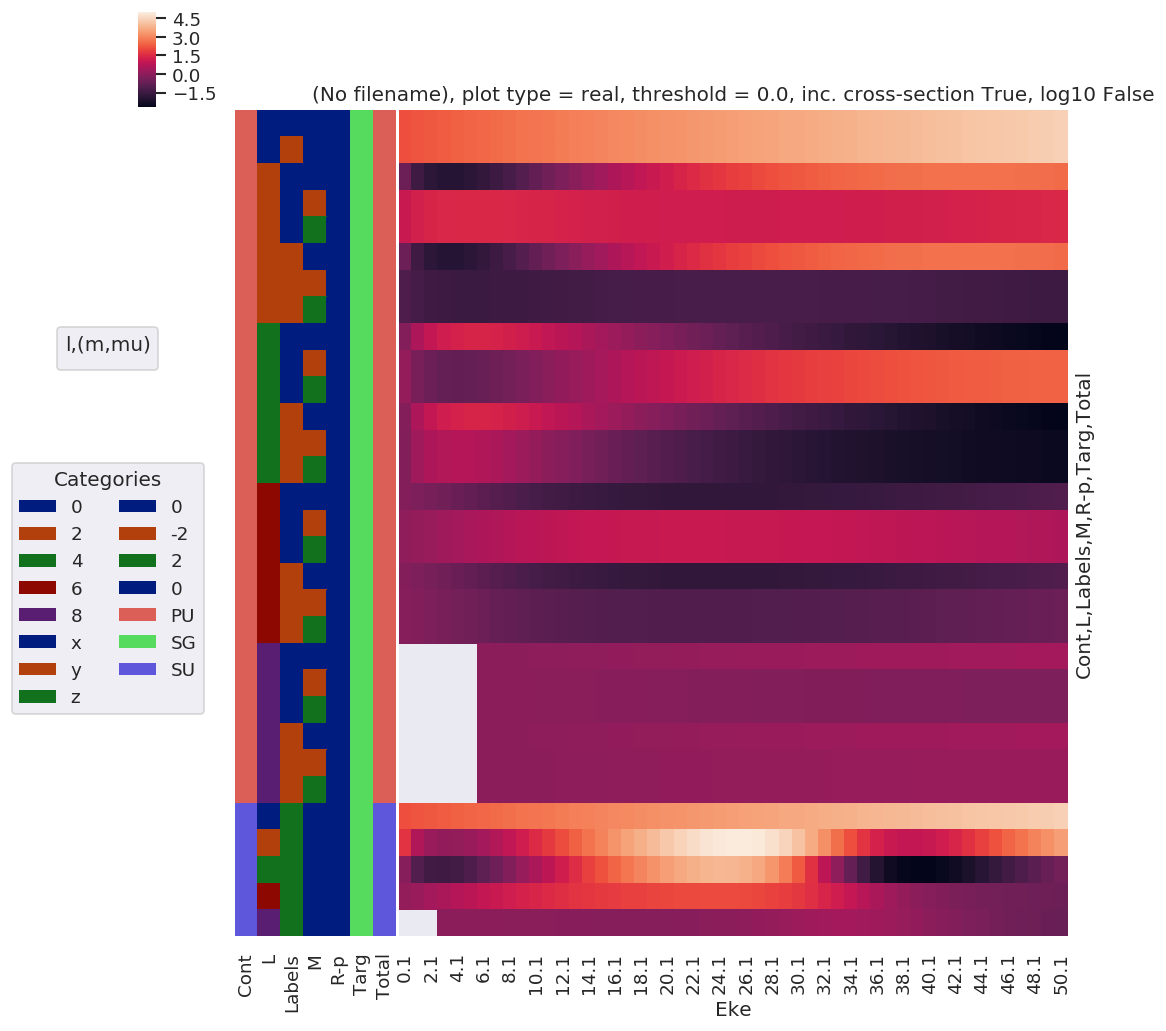

In [51]:
# Plot vs. Eke
mTermSumThres.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermSumThres, pType = 'r', thres = thres)

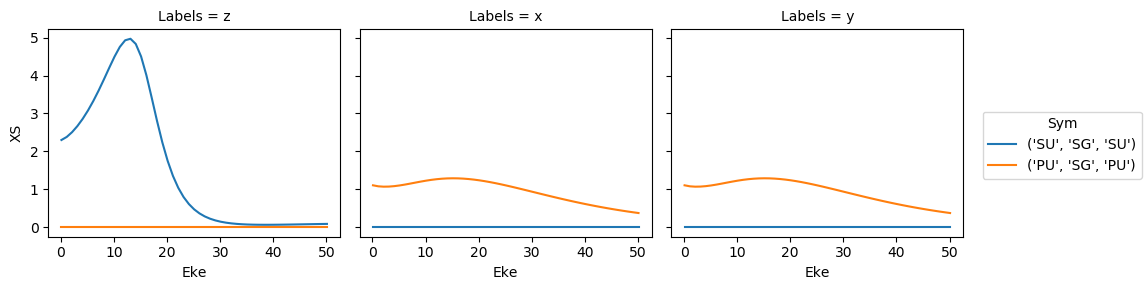

In [52]:
# Normalize and plot results
# BLM.XS.real.squeeze().plot.line(x='Eke', col='Euler');
# mTermSumThres.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.XS.real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.XS.sum(['R-p','Rp']).real.squeeze().plot.line(x='Eke', col='Labels');
mTermSumThres.XS.sum(['R-p']).real.squeeze().plot.line(x='Eke', col='Labels');

Hmmmm... current form shows correct 'shapes' of XS, but invariant to pol geom as seen previously.  Mu term mixing...?

09/04/20 - NOW CORRECTED!  Few bugs, main issue was missing additional $[P]^{(1/2)}$ term, which is not in EPR() defn. DOH!

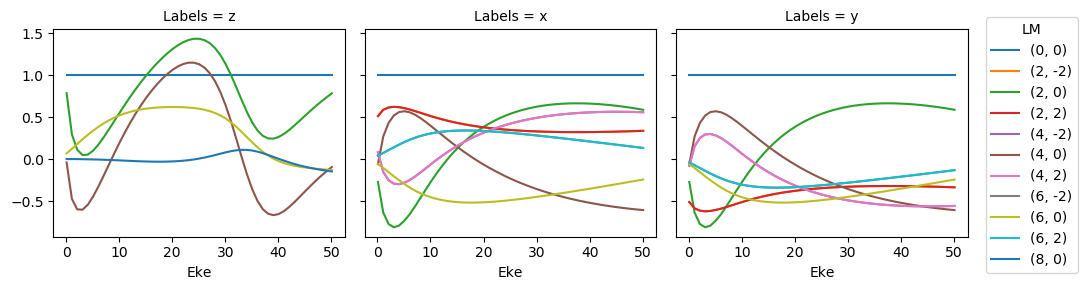

In [53]:
# Normalize and plot results
# ep.util.matEleSelector(BLM, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Euler');
# ep.util.matEleSelector(mTermSumThres.sum(['Cont', 'Total']), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');
ep.util.matEleSelector(mTermSumThres.sum(['R-p','Sym']).squeeze(), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');

### With pol selection

Trying to track down the source of problems above - lost dim correlation somewhere...?

In [54]:
# Recalc pol prod term for testing...

p = [0]
sumDimsPol = ['P','p']
normFlag = True

# Pol product term
polProdTest = (EPRXresort * lambdaTermResort)  # Without polarization terms sum to allow for mupPhase below (reqs. p)

# Set additional phase term, (-1)^(mup-p) **** THIS MIGHT BE SPURIOUS FOR GENERAL EPR TENSOR CASE??? Not sure... but definitely won't work if p summed over above!
# if phaseCons['mfblmCons']['mupPhase']:
#     mupPhaseTerm = np.power(-1, np.abs(polProdTest.mup - polProdTest.p))
#     polProdTest *= mupPhaseTerm

# Test different selection/summation
# polProdTest = polProdTest.sum(sumDimsPol)  #************** TO TEST - sum here OK???
# polProdTest = polProdTest.sel({'R':0}).sum(sumDimsPol)  # Same results
polProdTest = polProdTest.sum(sumDimsPol)   # With sum only over ['P','p'] - Same results
# polProdTest = polProdTest.sel({'Labels':'z'}).sum(sumDimsPol)  # Same result


In [55]:
mTerm = polProdTest * BLMprod

In [56]:
# Additional summation and norm
xDim = {'LM':['L','M']}

mTermSum = mTerm.sum(sumDims)

if squeeze is True:
    mTermSum = mTermSum.squeeze()  # Leave this as optional, since it can cause issues for M=0 only case

mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = thresDims)  # Thresholding is currently quite slow...?  Due to looping over dims?
#     mTermSumThres = mTermSum

# Normalise
# TODO: Set XS as per old mfpad()
#     BLMXout['XS'] = (('Eke','Euler'), BLMXout[0].data)  # Set XS = B00
#     BLMXout = BLMXout/BLMXout.XS  # Normalise

if normFlag:
    mTermSumThres['XS'] = mTermSumThres.sel({'L':0,'M':0}).drop('LM').copy()  # This basically works, and keeps all non-summed dims... but may give issues later...? Make sure to .copy(), otherwise it's just a pointer.
    mTermSumThres /= mTermSumThres.sel({'L':0,'M':0}).drop('LM')

Plotting data (No filename), pType=r, thres=0.001, with Seaborn


No handles with labels found to put in legend.


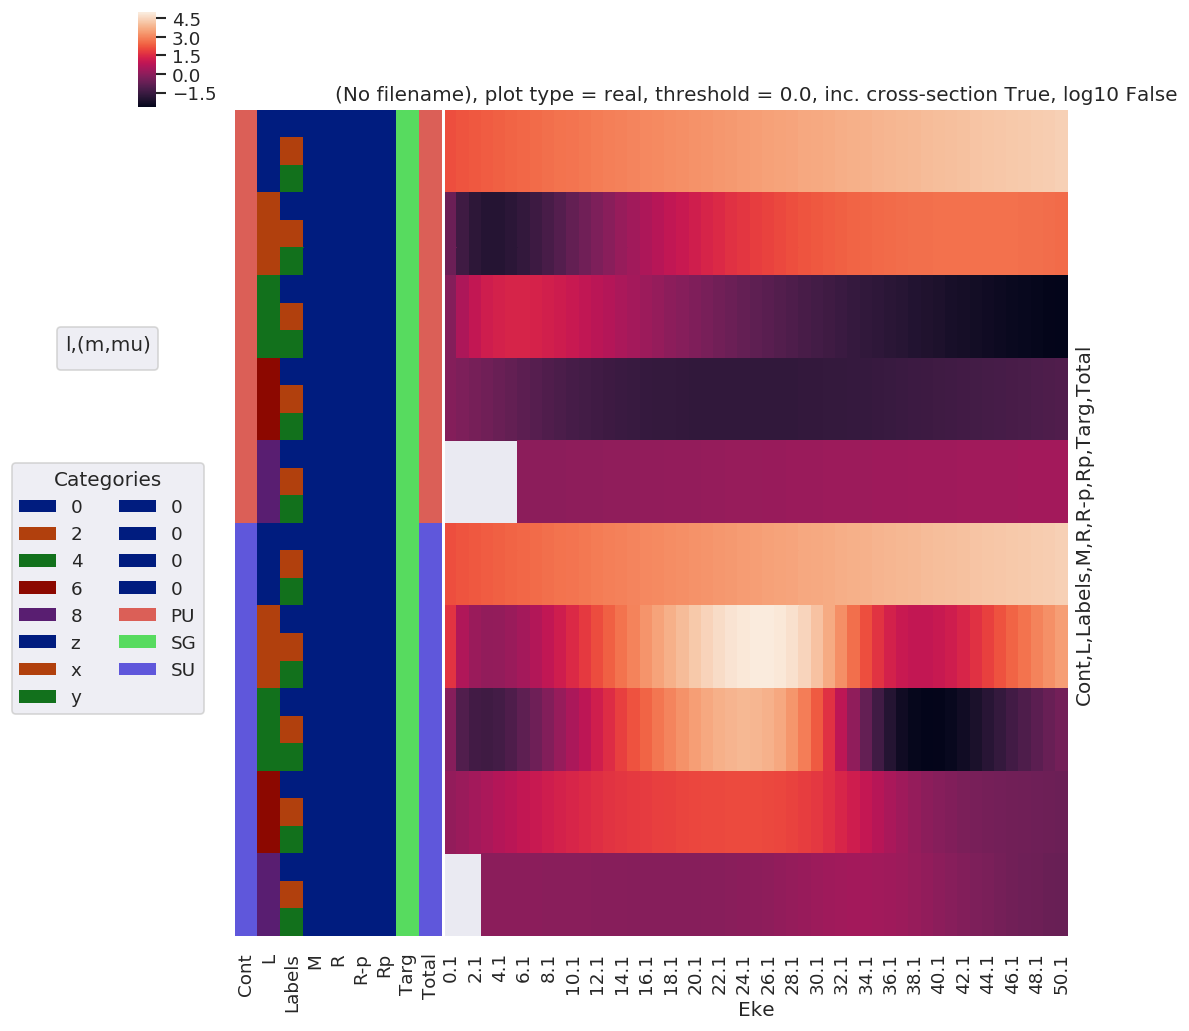

In [57]:
# Plot vs. Eke
mTermSumThres.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermSumThres, pType = 'r', thres = thres)

In [58]:
# Check complex values...
mTermSumThrespd, _ = ep.util.multiDimXrToPD(mTermSumThres, colDims='Eke', thres = thres)
mTermSumThrespd

Eke                                                0.1                 1.1   \
Cont L Labels M R R-p Rp Targ Total                                           
PU   0 z      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
       x      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
       y      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
     2 z      0 0 0   0  SG   PU    -0.272486-0.000000j -0.637673-0.000000j   
       x      0 0 0   0  SG   PU    -0.272486-0.000000j -0.637673-0.000000j   
       y      0 0 0   0  SG   PU    -0.272486-0.000000j -0.637673-0.000000j   
     4 z      0 0 0   0  SG   PU    -0.059137-0.000000j  0.269489-0.000000j   
       x      0 0 0   0  SG   PU    -0.059137-0.000000j  0.269489-0.000000j   
       y      0 0 0   0  SG   PU    -0.059137-0.000000j  0.269489-0.000000j   
     6 z      0 0 0   0  SG   PU    -0.059156-0.000000j -0.106111-0.000000j   
       x      0 0 0   0  SG   PU    -0.059156-0.000000j -0.106111-0.000000j   
       y      0 0 0   0  SG   PU    -0.059156-0.000000j -0.106111-0.000000j   
     8 z      0 0 0   0  SG   PU                    NaN                 NaN   
       x      0 0 0   0  SG   PU                    NaN                 NaN   
       y      0 0 0   0  SG   PU                    NaN                 NaN   
SU   0 z      0 0 0   0  SG   SU     1.000000+0.000000j  1.000000+0.000000j   
       x      0 0 0   0  SG   SU     1.000000+0.000000j  1.000000+0.000000j   
       y      0 0 0   0  SG   SU     1.000000+0.000000j  1.000000+0.000000j   
     2 z      0 0 0   0  SG   SU     0.785011+0.000000j  0.293449+0.000000j   
       x      0 0 0   0  SG   SU     0.785011+0.000000j  0.293449+0.000000j   
       y      0 0 0   0  SG   SU     0.785011+0.000000j  0.293449+0.000000j   
     4 z      0 0 0   0  SG   SU    -0.040440+0.000000j -0.474638+0.000000j   
       x      0 0 0   0  SG   SU    -0.040440+0.000000j -0.474638+0.000000j   
       y      0 0 0   0  SG   SU    -0.040440+0.000000j -0.474638+0.000000j   
     6 z      0 0 0   0  SG   SU     0.068194+0.000000j  0.122431+0.000000j   
       x      0 0 0   0  SG   SU     0.068194+0.000000j  0.122431+0.000000j   
       y      0 0 0   0  SG   SU     0.068194+0.000000j  0.122431+0.000000j   
     8 z      0 0 0   0  SG   SU                    NaN                 NaN   
       x      0 0 0   0  SG   SU                    NaN                 NaN   
       y      0 0 0   0  SG   SU                    NaN                 NaN   

Eke                                                2.1                 3.1   \
Cont L Labels M R R-p Rp Targ Total                                           
PU   0 z      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
       x      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
       y      0 0 0   0  SG   PU     1.000000-0.000000j  1.000000-0.000000j   
     2 z      0 0 0   0  SG   PU    -0.773735-0.000000j -0.812507-0.000000j   
       x      0 0 0   0  SG   PU    -0.773735-0.000000j -0.812507-0.000000j   
       y      0 0 0   0  SG   PU    -0.773735-0.000000j -0.812507-0.000000j   
     4 z      0 0 0   0  SG   PU     0.430702-0.000000j  0.519099-0.000000j   
       x      0 0 0   0  SG   PU     0.430702-0.000000j  0.519099-0.000000j   
       y      0 0 0   0  SG   PU     0.430702-0.000000j  0.519099-0.000000j   
     6 z      0 0 0   0  SG   PU    -0.155866-0.000000j -0.205371-0.000000j   
       x      0 0 0   0  SG   PU    -0.155866-0.000000j -0.205371-0.000000j   
       y      0 0 0   0  SG   PU    -0.155866-0.000000j -0.205371-0.000000j   
     8 z      0 0 0   0  SG   PU                    NaN                 NaN   
       x      0 0 0   0  SG   PU                    NaN                 NaN   
       y      0 0 0   0  SG   PU                    NaN                 NaN   
SU   0 z      0 0 0   0  SG   SU     1.000000+0.000000j  1.000000+0.000000j   
       x      0 0 0   0  SG   SU     1.000000+0.0

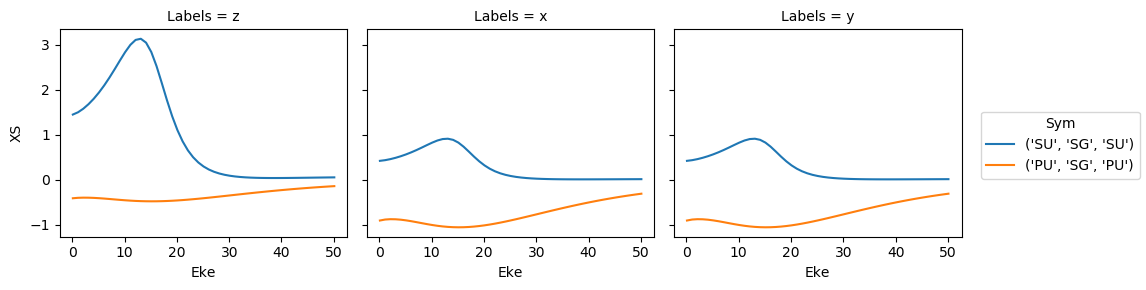

In [59]:
# Normalize and plot results
# BLM.XS.real.squeeze().plot.line(x='Eke', col='Euler');
# mTermSumThres.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.XS.real.squeeze().plot.line(x='Eke', col='Labels');
mTermSumThres.XS.sum(['R','Rp','R-p']).real.squeeze().plot.line(x='Eke', col='Labels');  # With R,Rp sum omitted previously - same results!

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

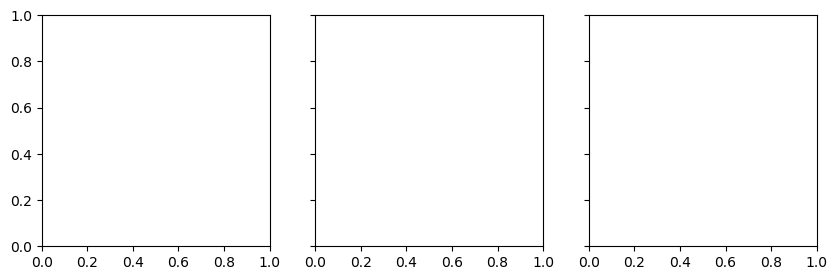

In [60]:
# Normalize and plot results
# ep.util.matEleSelector(BLM, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Euler');
# ep.util.matEleSelector(mTermSumThres.sum(['Cont', 'Total']), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');
ep.util.matEleSelector(mTermSumThres, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');

### With sym sum

In [ ]:
# Multiplication term polProd * BLMprod

# Phase & p-summation - already set above
# if phaseCons['mfblmCons']['mupPhase']:
#     mupPhaseTerm = np.power(-1, np.abs(polProd.mup - polProd.p))
#     polProd *= mupPhaseTerm

# polProd = polProd.sum(sumDimsPol)

# Test big mult...
# mTerm = polProd.sel({'R':0,'Labels':'z'}) * BLMprod.sum(['Total'])    # With selection of z geom.  # BLMprod.sum(['Cont', 'Targ', 'Total'])
# mTerm = polProd.sel({'R':0}) * BLMprod    # BLMprod.sum(['Cont', 'Targ', 'Total'])
mTerm = polProd * BLMprodSsym

In [ ]:
# Additional summation and norm
xDim = {'LM':['L','M']}

mTermSum = mTerm.sum(sumDims)

if squeeze is True:
    mTermSum = mTermSum.squeeze()  # Leave this as optional, since it can cause issues for M=0 only case

mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = thresDims)  # Thresholding is currently quite slow...?  Due to looping over dims?
#     mTermSumThres = mTermSum

# Normalise
# TODO: Set XS as per old mfpad()
#     BLMXout['XS'] = (('Eke','Euler'), BLMXout[0].data)  # Set XS = B00
#     BLMXout = BLMXout/BLMXout.XS  # Normalise
mTermSumThres['XS'] = mTermSumThres.sel({'L':0,'M':0}).drop('LM').copy()  # This basically works, and keeps all non-summed dims... but may give issues later...? Make sure to .copy(), otherwise it's just a pointer.
mTermSumThres /= mTermSumThres.sel({'L':0,'M':0}).drop('LM')

In [ ]:
# Plot vs. Eke
mTermSumThres.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermSumThres, pType = 'r', thres = thres)

In [ ]:
# Normalize and plot results
# BLM.XS.real.squeeze().plot.line(x='Eke', col='Euler');
# mTermSumThres.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
# mTermSumThres.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
mTermSumThres.XS.real.squeeze().plot.line(x='Eke', col='Labels');

## OLD NOTES BELOW

For various deprecated test cases, but might still be useful...

**Test using manual align options**

CONCLUSION: doesn't work in this case, presumably due to disparate dims being dropped. Manual align or join options can't fix this.

Q: IS THIS DEFINITELY WORKING for polProd term?  May also be accidentally droppping values/dims there too?

MORE TESTING: http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_Xarray_mult_testing_030420.ipynb

In [ ]:
with xr.set_options(arithmetic_join="inner"):  # Can select join method here, but nothing suitable, see http://xarray.pydata.org/en/stable/generated/xarray.merge.html
    BLMprod = matEmult * BLMtableResort

In [ ]:
# Plot vs. Eke
BLMprod.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprod, pType = 'r', thres = None)

In [ ]:
# Check align, http://xarray.pydata.org/en/stable/generated/xarray.align.html
a, b = xr.align(BLMtableResort, matEmult)
print(a.dims)
print(b.dims)

In [ ]:
c = a*b

In [ ]:
# Plot vs. Eke
c.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(c, pType = 'r', thres = None)

**Test dot product**

**Test using groupby**

http://xarray.pydata.org/en/stable/groupby.html

In [ ]:
CHECK DIMS AND m correlation in BLMTABLE!!!!!

In [ ]:
matEmultGrp = matEmult.groupby('Sym')
# BLMprodGrp = matEmultGrp * BLMtableResort.expand_dims('Sym')  # Same result as previously!!!  (==NaN along PU dims).  Need .expand_dims() otherwise multiplication fails completely.
BLMprodGrp = matEmultGrp.map(lambda x: x * BLMtableResort, shortcut=False)  # SAME RESULT!!!

# Try looping explicitly....
# for sym, da in matEmult.groupby('Sym'):
#     print(da.Sym)
#     print(da.min())
#     print(da.max())
#     daMult = da*BLMtableResort
#     print(daMult.dims)
#     print(daMult.min())
#     print(daMult.max())
    # Plot vs. Eke
#     daMult.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
#     daPlot, daPlotpd, legendList, gFig = ep.lmPlot(daMult, pType = 'a', thres = None)

In [ ]:
daMult.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(daMult, pType = 'a', thres = None)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprodGrp, pType = 'a', thres = None)

In [ ]:
# Plot vs. Eke
BLMprodGrp.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprodGrp.fillna(value = 0), pType = 'a', thres = None)